In [1]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

from scipy.interpolate import griddata

import networkx as nx
import torch_geometric
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim    

from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import torch

import time

from scipy.interpolate import griddata

from mpl_toolkits.basemap import Basemap

import cdsapi
import xarray as xr
from urllib.request import urlopen

from urllib.request import urlretrieve

import pickle

import scipy.io as sio

%load_ext autoreload
%autoreload 2

import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl import save_graphs, load_graphs
import torch
import os


from functions import *
from DGL_model import *

## Read sea ice OBSERVATION data

In [3]:
class ISSM_test_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_test_dataset_g20000.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

In [96]:
et0 = {}

for grid in [5000, 10000, 20000]:
    files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

    et0[grid] = np.zeros(len(files))

    train_list = []
    val_list = []
    i = 0

    for filename in tqdm(files[:1]):

        rate = float(filename[-7:-4])
        test = sio.loadmat(filename)

        xc = test['S'][0][0][0]
        yc = test['S'][0][0][1]
        elements = test['S'][0][0][2]-1

        smb = test['S'][0][0][3]
        vx = test['S'][0][0][4]
        vy = test['S'][0][0][5]
        vel = test['S'][0][0][6]
        H = test['S'][0][0][7]
        f = test['S'][0][0][8]

        et0[grid][i] = test['S'][0][0][9][0][0]
        i += 1
        
    print(grid, elements.shape, xc.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


5000 (4739, 3) (2468, 1)


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


10000 (2085, 3) (1112, 1)


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]

20000 (931, 3) (526, 1)


## Measure elapsed time

In [215]:
in_channels = 4
out_channels = 3

et1 = {}

for grid in [5000, 10000, 20000]:
    
    et1[grid] = {}
    test_set = load_graphs(f"../data/DGL_test_dataset_g{grid}.bin")[0]
    n_nodes = len(test_set[0].nodes())

    for model_type in ["mlp", "gcn", "gat", "egcn"]:

        if model_type == "gcn":
            model = GCN(in_channels, out_channels, 128)  # Graph convolutional network    
        elif model_type == "gin":
            model = GIN(in_channels, out_channels, 128)  # Equivariant Graph convolutional network
        elif model_type == "mlp":
            model = MLP(in_channels, out_channels, 128)  # Fully connected network
        elif model_type == "gat":
            model = GAT(in_channels, out_channels, 128)  # Graph convolutional network 
        elif model_type == "egcn":
            model = EGNNConv(in_channels, out_channels, 128, 1) # Equivariant Graph convolutional network
        elif model_type == "sage":
            model = SAGE(in_channels, out_channels, 128) # Equivariant Graph convolutional network
        elif model_type == "cheb":
            model = ChebGCN(in_channels, out_channels, 128)  # Equivariant Graph convolutional network   

        for device_name in ["cpu", "cuda"]:

            emulator = f"C:\\Users\\yok223\\Research\\ISSM\\model\\torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch3.pth"
            device = torch.device(device_name)

            if device_name == "cuda":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
            elif device_name == "cpu":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
                model = model.module.to(device)

            # model.load_state_dict(torch.load(emulator))

            # model.to(device)
            model.eval()

            for k, bg in enumerate(test_set):
                pass

            et1[grid][model_type + "_" + device_name] = np.zeros(len(files))

            i = 0
            bg = test_set[0].to(device)

            for r in tqdm(np.arange(0, 71, 2)):

                for y in np.arange(0, 20, 1/12):

                    feats = bg.ndata['feat'][:, :-1]
                    feats[:, 2] = r * 0.001
                    feats[:, 3] = y/20
                    coord_feat = bg.ndata['feat'][:, :2]
                    edge_feat = bg.edata['weight'].float() #.repeat(1, 2)            

                    if out_channels > 3:
                        labels = bg.ndata['label']
                    elif out_channels == 3:
                        labels = bg.ndata['label'][:, [0,1,3]]  

                    t0 = time.time()

                    with torch.no_grad():
                        if model_type == "egcn":
                            pred = model(bg, feats, coord_feat, edge_feat)
                            labels = torch.cat([labels, coord_feat], dim=1)
                        else:
                            pred = model(bg, feats)

                    et1[grid][model_type + "_" + device_name][i] += time.time() - t0
                    
                i += 1
                
        print(model_type, grid)

  0%|                                                                                        | 0/36 [00:02<?, ?it/s]

KeyboardInterrupt



In [322]:
test_loader = GraphDataLoader(test_set[:240], batch_size=240, shuffle=False)

In [324]:
part_set = test_set[:240]
len(part_set)

240

In [315]:
for i, bg in enumerate(test_loader):
    test_loader[i].ndata['feats'][:, 2] = r * 0.001

Dataset("pig", num_graphs=960, save_path=C:\Users\yok223\.dgl\pig_3111e42e)

## GNN

In [218]:
in_channels = 4
out_channels = 3

et1 = {}

for grid in [5000, 10000, 20000]:
    
    et1[grid] = {}
    test_set = load_graphs(f"../data/DGL_test_dataset_g{grid}.bin")[0]
    n_nodes = len(test_set[0].nodes())

    for model_type in ["mlp", "gcn", "gat", "egcn"]:

        if model_type == "gcn":
            model = GCN(in_channels, out_channels, 128)  # Graph convolutional network    
        elif model_type == "gin":
            model = GIN(in_channels, out_channels, 128)  # Equivariant Graph convolutional network
        elif model_type == "mlp":
            model = MLP(in_channels, out_channels, 128)  # Fully connected network
        elif model_type == "gat":
            model = GAT(in_channels, out_channels, 128)  # Graph convolutional network 
        elif model_type == "egcn":
            model = EGNNConv(in_channels, out_channels, 128, 1) # Equivariant Graph convolutional network
        elif model_type == "sage":
            model = SAGE(in_channels, out_channels, 128) # Equivariant Graph convolutional network
        elif model_type == "cheb":
            model = ChebGCN(in_channels, out_channels, 128)  # Equivariant Graph convolutional network   

        for device_name in ["cpu", "cuda"]:

            emulator = f"C:\\Users\\yok223\\Research\\ISSM\\model\\torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch{out_channels}.pth"
            device = torch.device(device_name)

            if device_name == "cuda":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
                model = model.to(device)
            elif device_name == "cpu":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
                model = model.module.to(device)

            # model.load_state_dict(torch.load(emulator))

            # model.to(device)
            model.eval()

            for k, bg in enumerate(test_set):
                pass

            et1[grid][model_type + "_" + device_name] = np.zeros(len(files))

            i = 0
            # bg = test_set[0].to(device)
            
            for r in tqdm(np.arange(0, 71, 2)):
                
                part_set = test_set[:240]
                
                for k in range(0, len(part_set)):
                    part_set[k].ndata['feat'][:, 2] = r * 0.001
                
                test_loader = GraphDataLoader(part_set, batch_size=12, shuffle=False)    
                
                for bg in test_loader:
                    
                    t0 = time.time()
                    
                    bg = bg.to(device)
                    feats = bg.ndata['feat'][:, :-1]
                    coord_feat = bg.ndata['feat'][:, :2]
                    edge_feat = bg.edata['weight'].float() #.repeat(1, 2)
                    if out_channels > 3:
                        labels = bg.ndata['label']
                    elif out_channels == 3:
                        labels = bg.ndata['label'][:, [0,1,3]]               

                    with torch.no_grad():
                        if model_type == "egcn":
                            pred = model(bg, feats, coord_feat, edge_feat)
                            labels = torch.cat([labels, coord_feat], dim=1)
                        else:
                            pred = model(bg, feats)
                
                    et1[grid][model_type + "_" + device_name][i] += time.time() - t0
                    
                i += 1
                
        print(model_type, grid)

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.38it/s]


mlp 5000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:20<00:00,  1.73it/s]


gcn 5000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:24<00:00,  1.50it/s]


gat 5000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:24<00:00,  1.46it/s]


egcn 5000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


mlp 10000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:16<00:00,  2.16it/s]


gcn 10000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:19<00:00,  1.83it/s]


gat 10000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.95it/s]


egcn 10000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.94it/s]


mlp 20000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:15<00:00,  2.29it/s]


gcn 20000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.06it/s]


gat 20000


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.02it/s]

egcn 20000


In [154]:
in_channels = 4
out_channels = 3

et2 = {}

for grid in [5000, 10000, 20000]:  
    
    et2[grid] = {}
    
    with open(f'../data/CNN_dataset_g{grid}.pkl', 'rb') as file:
        [grid_input, grid_output, train_index] = pickle.load(file)
        
    mask = torch.isnan(torch.tensor(grid_input[0, 0]))
        
    test_graphs = load_graphs(f"../data/DGL_test_dataset_g{grid}.bin")[0]
    n_nodes = len(test_graphs[0].nodes())
    
    xy = test_graphs[0].ndata['feat'][:, 0:2]
    sampling = torch.zeros(xy.shape, dtype=torch.int)

    for model_type in ["fcn"]:

        if model_type == "fcn":
            model = FCN(in_channels, out_channels, 128)

        for device_name in ["cpu", "cuda"]:
            if model_type == "fcn":
                emulator = f"C:\\Users\\yok223\\Research\\ISSM\\model\\torch_dgl_{model_type}_{n_nodes}_lr0.001_nophy_ch{out_channels}.pth"
            else:
                emulator = f"C:\\Users\\yok223\\Research\\ISSM\\model\\torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch{out_channels}.pth"
            device = torch.device(device_name)

            if device_name == "cuda":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
                model = model.to(device)
            elif device_name == "cpu":
                model = nn.DataParallel(model)
                model.load_state_dict(torch.load(emulator, map_location=device))
                model = model.module.to(device)

            # model.load_state_dict(torch.load(emulator))

            # model.to(device)
            model.eval()

            et2[grid][model_type + "_" + device_name] = np.zeros(len(files))

            i = 0
            # bg = test_set[0].to(device)
            
            for r in tqdm(np.arange(0, 71, 2)):             
                
                part_set = torch.tensor(grid_input[:240, :-1], dtype=torch.float32)
                part_set[:, 2] = r * 0.001
                
                test_loader = DataLoader(part_set, batch_size=24, shuffle=False)    
                
                for bg in test_loader:     
                    
                    t0 = time.time()

                    with torch.no_grad():
                        pred = model(bg, sampling)
                
                    et2[grid][model_type + "_" + device_name][i] += time.time() - t0
                    
                i += 1
                
        print(model_type, grid)

100%|███████████████████████████████████████████████████████████████████████████| 36/36 [00:37<00:00,  1.05s/it]


fcn 5000


100%|███████████████████████████████████████████████████████████████████████████| 36/36 [00:37<00:00,  1.04s/it]


fcn 10000


100%|███████████████████████████████████████████████████████████████████████████| 36/36 [00:37<00:00,  1.05s/it]

fcn 20000


In [206]:
et2

{5000: {'fcn_cpu': array([53.06948996, 53.05243564, 53.75795674, 53.5032618 , 52.49205923,
         52.89218307, 53.8824563 , 53.01834798, 53.99135995, 53.01345658,
         51.93010259, 53.45925903, 53.05574131, 53.15593529, 54.35275626,
         53.66021991, 52.73772144, 52.95310521, 53.42729497, 52.90594864,
         53.25021815, 53.78535962, 52.77841043, 52.6623261 , 53.9039669 ,
         54.91917443, 54.32981586, 54.19527864, 54.80106759, 55.29991317,
         55.5526793 , 53.74184442, 53.87499046, 56.19494486, 54.25378823,
         54.14894938]),
  'fcn_cuda': array([0.10227585, 0.09522033, 0.05465484, 0.23572135, 1.01081252,
         1.04154301, 1.02481961, 1.03706837, 1.02176571, 1.01238132,
         1.02081251, 1.0179255 , 1.02852535, 1.04043531, 1.03024602,
         1.03853416, 1.03281641, 1.02579284, 1.0296042 , 1.03280973,
         1.01133752, 1.03849983, 1.01413703, 1.01954675, 1.00863814,
         1.03521895, 1.02069139, 1.02039337, 1.02224636, 1.03227115,
         1.0199

In [146]:
for r in tqdm(np.arange(0, 71, 2)):
                
    t0 = time.time()

    part_set = torch.tensor(grid_input[:240, :-1], dtype=torch.float32)
    part_set[:, 2] = r * 0.001

    test_loader = DataLoader(part_set, batch_size=24, shuffle=False)    

    for bg in test_loader:          

        with torch.no_grad():
            pred = model(bg, sampling)

        et2[grid][model_type + "_" + device_name][i] += time.time() - t0

  3%|██                                                                          | 1/36 [01:00<35:27, 60.77s/it]

KeyboardInterrupt



In [363]:
for bg in test_loader:
    bg = bg.to(device)
    feats = bg.ndata['feat'][:, :-1]
    coord_feat = bg.ndata['feat'][:, :2]
    edge_feat = bg.edata['weight'].float() #.repeat(1, 2)
    if out_channels > 3:
        labels = bg.ndata['label']
    elif out_channels == 3:
        labels = bg.ndata['label'][:, [0,1,3]]

    t0 = time.time()

    with torch.no_grad():
        if model_type == "egcn":
            pred = model(bg, feats, coord_feat, edge_feat)
            labels = torch.cat([labels, coord_feat], dim=1)
        else:
            pred = model(bg, feats)
            
    print(time.time() - t0)

0.0067386627197265625


In [219]:
df = pd.DataFrame({})

for grid in [5000, 10000, 20000]:
    df.loc[grid, "ISSM"] = np.sum(et0[grid])
    for model_type in ["mlp", "gcn", "gat", "egcn"]:  
        for device_name in ["cpu", "cuda"]:
            df.loc[grid, model_type + "_" + device_name] = np.sum(et1[grid][model_type + "_" + device_name])
            
df.to_csv("D:\\ISSM\\Elapse_time2.csv")

In [220]:
df

ISSM    mlp_cpu  mlp_cuda     gcn_cpu   gcn_cuda     gat_cpu  \
5000   23.426280  25.017324  2.985187  125.046803  14.177017  467.780013   
10000  12.471121  11.715118  2.367174   60.369197  11.832201  216.724846   
20000   7.619316   6.757725  1.913799   34.498774  11.991919  104.163282   

        gat_cuda    egcn_cpu  egcn_cuda  
5000   16.498488  607.769916  16.142508  
10000  13.727863  282.460858   6.363022  
20000  13.131461  134.309824   5.294016

In [207]:
df = pd.DataFrame({})

for grid in [5000, 10000, 20000]:
    # df.loc[grid, "ISSM"] = np.sum(et0[grid])
    for model_type in ["fcn"]:  
        for device_name in ["cpu", "cuda"]:
            df.loc[grid, model_type + "_" + device_name] = np.sum(et2[grid][model_type + "_" + device_name])
            
df.to_csv("D:\\ISSM\\Elapse_time_fcn.csv")

In [208]:
df

fcn_cpu   fcn_cuda
5000   1932.003819  33.343415
10000  1859.654932  33.266948
20000  1834.680720  32.928586

In [247]:
df

ISSM    mlp_cpu  mlp_cuda     gcn_cpu   gcn_cuda     gat_cpu  \
5000   712.960581  24.294696  2.889018  111.775693  12.075298  436.468811   
10000  399.779414  11.816025  0.656496   57.236379  10.917642  210.219998   
20000  209.851088   6.454705  0.637997   31.304649  12.238199  102.428310   

        gat_cuda    egcn_cpu  egcn_cuda  
5000   14.045511  613.005587   3.866343  
10000  12.212027  280.260376   4.403155  
20000  11.837629  132.821391   4.297287

In [166]:
files = glob.glob('D:\\ISSM\\version2\\transient_g5000_y20_r*.mat')

train_list = []
val_list = []

for filename in tqdm(files[:1]):
    
    rate = float(filename[-7:-4])
    test = sio.loadmat(filename)
    elements = test['S'][0][0][2]-1

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


In [46]:
files = glob.glob('D:\\ISSM\\version2\\transient_y20_r*.mat')

train_list = []
val_list = []

for filename in tqdm(files[:1]):
    
    rate = float(filename[-7:-4])
    test = sio.loadmat(filename)
    
    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    elements = test['S'][0][0][2]-1

    smb = test['S'][0][0][3]
    vx = test['S'][0][0][4]
    vy = test['S'][0][0][5]
    vel = test['S'][0][0][6]
    H = test['S'][0][0][7]
    f = test['S'][0][0][8]

    n_year, n_sample = H.shape

    for t in range(0, n_year):
        
        src = []
        dst = []
        weight = []
        inputs = torch.zeros([n_sample, 4])
        outputs = torch.zeros([n_sample, 6])

        for i in range(0, n_sample): 
            inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year])
            outputs[i, :] = torch.tensor([smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

            p1, p2 = np.where(elements == i)

            for p in p1:
                for k in elements[p]:
                    if k != i:
                        dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                        weight.append(np.exp(-(dist/1000)))
                        src.append(int(i))
                        dst.append(int(k))
        
        src = torch.tensor(src)
        dst = torch.tensor(dst)
        weight = torch.tensor(weight)
        
        g = dgl.graph((src, dst), num_nodes=n_sample)
        g.ndata['feat'] = inputs
        g.ndata['label'] = outputs
        g.edata['weight'] = weight


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.56s/it]


In [10]:
PIG_train_Dataset()

TypeError: PIG_train_Dataset.__init__() missing 1 required positional argument: 'filename'

In [156]:
filename = 'D:\\ISSM\\version2\\transient_HO_g10000_y20_r*.mat'

## Dataset for train ===================================
class PIG_train_Dataset(DGLDataset):
    def __init__(self):
        super(PIG_train_Dataset, self).__init__(name='pig');
        
    def process(self):
        self.graphs = []
        filename = 'D:\\ISSM\\version2\\transient_g5000_y20_r*.mat'
        files = glob.glob(filename)

        for filename in tqdm(files[:]):

            rate = float(filename[-7:-4])
            
            if (rate % 200 != 0) and (rate % 200 != 100):
                
                test = sio.loadmat(filename)

                xc = test['S'][0][0][0]
                yc = test['S'][0][0][1]
                elements = test['S'][0][0][2]-1

                smb = test['S'][0][0][3]
                vx = test['S'][0][0][4]
                vy = test['S'][0][0][5]
                vel = test['S'][0][0][6]
                H = test['S'][0][0][7]
                f = test['S'][0][0][8]

                n_year, n_sample = H.shape          

                for t in range(0, n_year):

                    src = []
                    dst = []
                    weight = []
                    inputs = torch.zeros([n_sample, 5])
                    outputs = torch.zeros([n_sample, 5])

                    for i in range(0, n_sample):        
                        inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year, smb[t,i]])
                        outputs[i, :] = torch.tensor([vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

                        p1, p2 = np.where(elements == i)
                        connect = []

                        for p in p1:
                            for k in elements[p]:
                                if (k != i) and (k not in connect):
                                    # connect.append(k)
                                    dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                                    weight.append(np.exp(-(dist/1000)))
                                    src.append(int(i))
                                    dst.append(int(k))

                    src = torch.tensor(src)
                    dst = torch.tensor(dst)
                    weight = torch.tensor(weight)

    #                 train_mask = torch.zeros(n_sample, dtype=torch.bool)
    #                 val_mask = torch.zeros(n_sample, dtype=torch.bool)
    #                 test_mask = torch.zeros(n_sample, dtype=torch.bool)        

    #                 if rate % 100 == 0:
    #                     test_mask[:] = True
    #                 else:
    #                     if t % 10 == 5:
    #                         val_mask[:] = True
    #                     else:
    #                         train_mask[:] = True

                    g = dgl.graph((src, dst), num_nodes=n_sample)
                    g.ndata['feat'] = inputs
                    g.ndata['label'] = outputs
                    g.edata['weight'] = weight

    #                 g.ndata['train_mask'] = train_mask
    #                 g.ndata['val_mask'] = val_mask
    #                 g.ndata['test_mask'] = test_mask

                    self.graphs.append(g)
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

## Dataset for test ===================================
class PIG_val_Dataset(DGLDataset):
    def __init__(self):
        super(PIG_val_Dataset, self).__init__(name='pig')
        
    def process(self):
        self.graphs = []
        
        filename = 'D:\\ISSM\\version2\\transient_g5000_y20_r*.mat'
        files = glob.glob(filename)

        for filename in tqdm(files[:]):

            rate = float(filename[-7:-4])
            
            if rate % 200 == 100:
            
                test = sio.loadmat(filename)

                xc = test['S'][0][0][0]
                yc = test['S'][0][0][1]
                elements = test['S'][0][0][2]-1

                smb = test['S'][0][0][3]
                vx = test['S'][0][0][4]
                vy = test['S'][0][0][5]
                vel = test['S'][0][0][6]
                H = test['S'][0][0][7]
                f = test['S'][0][0][8]

                n_year, n_sample = H.shape          

                for t in range(0, n_year):

                    src = []
                    dst = []
                    weight = []
                    inputs = torch.zeros([n_sample, 5])
                    outputs = torch.zeros([n_sample, 5])

                    for i in range(0, n_sample):        
                        inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year, smb[t,i]])
                        outputs[i, :] = torch.tensor([vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

                        p1, p2 = np.where(elements == i)
                        connect = []

                        for p in p1:
                            for k in elements[p]:
                                if (k != i) and (k not in connect):
                                    # connect.append(k)
                                    dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                                    weight.append(np.exp(-(dist/1000)))
                                    src.append(int(i))
                                    dst.append(int(k))

                    src = torch.tensor(src)
                    dst = torch.tensor(dst)
                    weight = torch.tensor(weight)

                    g = dgl.graph((src, dst), num_nodes=n_sample)
                    g.ndata['feat'] = inputs
                    g.ndata['label'] = outputs
                    g.edata['weight'] = weight

                    self.graphs.append(g)
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

## Dataset for test ===================================
class PIG_test_Dataset(DGLDataset):
    def __init__(self):
        super(PIG_test_Dataset, self).__init__(name='pig')
        
    def process(self):
        self.graphs = []
        
        filename = 'D:\\ISSM\\version2\\transient_g5000_y20_r*.mat'
        files = glob.glob(filename)

        for filename in tqdm(files[:]):

            rate = float(filename[-7:-4])
            
            if rate % 200 == 0:
            
                test = sio.loadmat(filename)

                xc = test['S'][0][0][0]
                yc = test['S'][0][0][1]
                elements = test['S'][0][0][2]-1

                smb = test['S'][0][0][3]
                vx = test['S'][0][0][4]
                vy = test['S'][0][0][5]
                vel = test['S'][0][0][6]
                H = test['S'][0][0][7]
                f = test['S'][0][0][8]

                n_year, n_sample = H.shape          

                for t in range(0, n_year):

                    src = []
                    dst = []
                    weight = []
                    inputs = torch.zeros([n_sample, 5])
                    outputs = torch.zeros([n_sample, 5])

                    for i in range(0, n_sample):        
                        inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year, smb[t,i]])
                        outputs[i, :] = torch.tensor([vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

                        p1, p2 = np.where(elements == i)
                        connect = []

                        for p in p1:
                            for k in elements[p]:
                                if (k != i) and (k not in connect):
                                    # connect.append(k)
                                    dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                                    weight.append(np.exp(-(dist/1000)))
                                    src.append(int(i))
                                    dst.append(int(k))

                    src = torch.tensor(src)
                    dst = torch.tensor(dst)
                    weight = torch.tensor(weight)

                    g = dgl.graph((src, dst), num_nodes=n_sample)
                    g.ndata['feat'] = inputs
                    g.ndata['label'] = outputs
                    g.edata['weight'] = weight

                    self.graphs.append(g)
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
train_set = PIG_train_Dataset()
save_graphs("../data/DGL_train_dataset_g5000.bin", train_set.graphs)

val_set = PIG_val_Dataset()
save_graphs("../data/DGL_val_dataset_g5000.bin", val_set.graphs)

test_set = PIG_test_Dataset()
save_graphs("../data/DGL_test_dataset_g5000.bin", test_set.graphs)
print("Done!")

100%|████████████████████████████████████████████████████████████████████████████| 36/36 [2:30:35<00:00, 250.99s/it]


Done!


In [17]:
save_graphs("../data/DGL_train_dataset_g5000.bin", train_set.graphs)

In [18]:
save_graphs("../data/DGL_val_dataset_g5000.bin", val_set.graphs)

In [19]:
save_graphs("../data/DGL_test_dataset_g5000.bin", test_set.graphs)

In [284]:
from dgl import save_graphs, load_graphs

class ISSM_train_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_train_dataset.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
class ISSM_test_dataset(DGLDataset):
    def __init__(self, filename):
        super().__init__(name="pig", url = filename)
        
    def process(self):
        glist, _ = load_graphs(self.url)
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

In [271]:
train_set = ISSM_train_dataset()

In [276]:
train_set.url

In [285]:
test_set = ISSM_test_dataset("../data/DGL_test_dataset_g10000.bin")

In [287]:
test_set[0]

Graph(num_nodes=1112, num_edges=12510,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32), 'label': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})

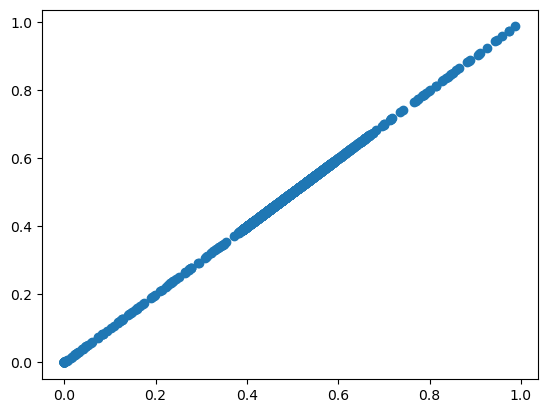

In [152]:
plt.scatter(train_set[1000].ndata['label'][:, 0], train_set[0].ndata['label'][:, 0])

In [127]:
ds[0].ndata['label'].shape

torch.Size([1112, 6])

In [99]:
ds[0].ndata['train_mask']

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [100]:
from dgl.data import split_dataset
from dgl.dataloading import GraphDataLoader

def get_dataloaders(dataset, seed, batch_size=32):
    # Use a 80:10:10 train-val-test split
    train_set, val_set, test_set = split_dataset(dataset,
                                                 frac_list=[0.8, 0.1, 0.1],
                                                 shuffle=True,
                                                 random_state=seed)
    train_loader = GraphDataLoader(train_set, use_ddp=True, batch_size=batch_size, shuffle=True)
    val_loader = GraphDataLoader(val_set, batch_size=batch_size)
    test_loader = GraphDataLoader(test_set, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [117]:
train_loader

8640

In [118]:
loader = GraphDataLoader(ds, batch_size=len(ds), shuffle=True)

In [121]:
for bg in loader:
    b = bg.ndata['feat']

In [180]:
model = MLP(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

model = GCN(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

model = GIN(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

50950
50950
50950


In [235]:
from dgl.nn import EGNNConv

g = dgl.graph(([0,1,2,3,2,5,4,3], [1,2,3,4,0,3,1,3]))
node_feat, coord_feat, edge_feat = torch.rand(6, 10), torch.rand(6, 2), torch.rand(8, 2)
model = EGNNConv(10, 10, 10, 2)
# EGNNConv(in_size, hidden_size, out_size, edge_feat_size=0)
h, x = model(g, node_feat, coord_feat, edge_feat)

In [276]:
import dgl
import numpy as np
from dgl.nn import GATConv

# Case 1: Homogeneous graph

g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
g = dgl.add_self_loop(g)
feat = torch.ones((6, 10))
gatconv = GATConv(10, 2, num_heads=3)
res = gatconv(g, feat)
res.shape

torch.Size([6, 3, 2])

In [279]:
torch.mean(res, dim = 1).shape

torch.Size([6, 2])

In [243]:
node_feat = bg.ndata['feat']
print(node_feat.shape, node_feat.dtype)
coord_feat = bg.ndata['feat'][:, :2]
print(coord_feat.shape, coord_feat.dtype)
edge_feat = bg.edata['weight'].float() #.repeat(1, 2)
print(edge_feat.shape, edge_feat.dtype)

torch.Size([17792, 4]) torch.float32
torch.Size([17792, 2]) torch.float32
torch.Size([200160, 1]) torch.float32


In [245]:
model = EGNNConv(4, 128, 6, 1)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

52358


In [241]:
edge_feat.dtype

torch.float32

In [246]:
h, x = model(bg, node_feat, coord_feat, edge_feat)

In [247]:
h.shape

torch.Size([17792, 6])

In [256]:
pred = torch.cat([node_feat, coord_feat], dim=1)
pred.shape

torch.Size([17792, 6])

In [254]:
fn.copy_e

<function dgl.function.message.copy_e(e, out)>

In [192]:
bg.edata['weight']

tensor([[0.0145],
        [0.5091],
        [0.0145],
        ...,
        [0.2324],
        [0.1446],
        [0.0005]], dtype=torch.float64)

In [169]:
for bg in train_loader:
    feats = bg.ndata['feat']
    labels = bg.ndata['label']
          
    pred = model(bg, feats)

In [170]:
pred.shape

torch.Size([17792, 6])

In [223]:
for bg in train_loader:
    a = bg.ndata

In [161]:
a['label'].shape

torch.Size([17792, 6])

50950

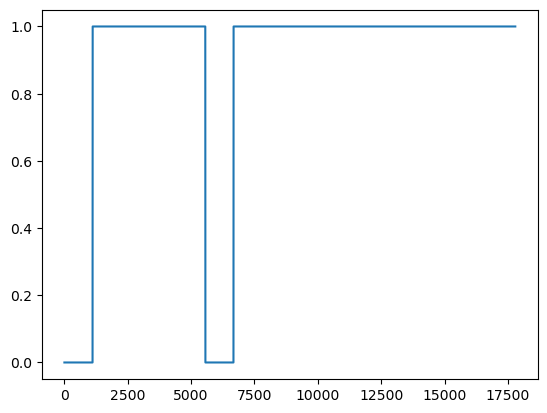

In [115]:
plt.plot(a['train_mask'])

In [107]:
train_set, val_set, test_set = split_dataset(ds,
                                             frac_list=[0.8, 0.1, 0.1],
                                             shuffle=True,
                                             random_state=0)

In [487]:
files = glob.glob('D:\\ISSM\\version2\\transient_y20_r*.mat')

for filename in tqdm(files[:1]):

    rate = float(filename[-7:-4])
    test = sio.loadmat(filename)

    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    elements = test['S'][0][0][2]-1

    smb = test['S'][0][0][3]
    vx = test['S'][0][0][4]
    vy = test['S'][0][0][5]
    vel = test['S'][0][0][6]
    H = test['S'][0][0][7]
    f = test['S'][0][0][8]


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


In [491]:
xc.max()

xmax = -1360067.937381
xmin = -1794277.962227
ymax = 63667.6809196406
ymin = -373562.027065861

-1360067.937381

In [494]:
yc.max() - yc.min()

437229.70798550156

In [66]:
class PIGDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        self.graphs = []
        
        files = glob.glob('D:\\ISSM\\version2\\transient_y20_r*.mat')

        for filename in tqdm(files[:]):

            rate = float(filename[-7:-4])
            test = sio.loadmat(filename)

            xc = test['S'][0][0][0]
            yc = test['S'][0][0][1]
            elements = test['S'][0][0][2]-1

            smb = test['S'][0][0][3]
            vx = test['S'][0][0][4]
            vy = test['S'][0][0][5]
            vel = test['S'][0][0][6]
            H = test['S'][0][0][7]
            f = test['S'][0][0][8]

            n_year, n_sample = H.shape

            for t in range(0, n_year):

                src = []
                dst = []
                weight = []
                inputs = torch.zeros([n_sample, 4])
                outputs = torch.zeros([n_sample, 6])

                for i in range(0, n_sample):        
                    inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year])
                    outputs[i, :] = torch.tensor([smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

                    p1, p2 = np.where(elements == i)

                    for p in p1:
                        for k in elements[p]:
                            if k != i:
                                dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                                weight.append(np.exp(-(dist/1000)))
                                src.append(int(i))
                                dst.append(int(k))

                src = torch.tensor(src)
                dst = torch.tensor(dst)
                weight = torch.tensor(weight)
                
                train_mask = torch.zeros(n_sample, dtype=torch.bool)
                val_mask = torch.zeros(n_sample, dtype=torch.bool)
                test_mask = torch.zeros(n_sample, dtype=torch.bool)        
                                        
                if rate % 100 == 0:
                    test_mask[:] = True
                else:
                    if t % 10 == 5:
                        val_mask[:] = True
                    else:
                        train_mask[:] = True

                g = dgl.graph((src, dst), num_nodes=n_sample)
                g.ndata['feat'] = inputs
                g.ndata['label'] = outputs
                g.edata['weight'] = weight
                
                g.ndata['train_mask'] = train_mask
                g.ndata['val_mask'] = val_mask
                g.ndata['test_mask'] = test_mask

                self.graphs.append(g)
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

5

In [ ]:
import os
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info

def save(self):
    # save graphs and labels
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    save_graphs(graph_path, self.graphs)

In [70]:
train_mask = torch.zeros(5, dtype=torch.bool)
print(train_mask)

tensor([False, False, False, False, False])


In [71]:
train_mask[:] = True
print(train_mask)

tensor([True, True, True, True, True])


In [60]:
from dgl.data.utils import save_graphs, load_graphs

save_graphs("../data/PIG_DGL_dataset.bin", dataset.graphs)

In [4]:
import dgl
from dgl.data import DGLDataset
import torch
import os

nodes_data = pd.read_csv('./members.csv')
edges_data = pd.read_csv('./interactions.csv')
node_features = torch.from_numpy(nodes_data['Age'].to_numpy())
node_labels = torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy())
edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
edges_src = torch.from_numpy(edges_data['Src'].to_numpy())
edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())

self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
self.graph.ndata['feat'] = node_features
self.graph.ndata['label'] = node_labels
self.graph.edata['weight'] = edge_features

# If your dataset is a node classification dataset, you will need to assign
# masks indicating whether a node belongs to training, validation, and test set.
n_nodes = nodes_data.shape[0]
n_train = int(n_nodes * 0.6)
n_val = int(n_nodes * 0.2)
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)
train_mask[:n_train] = True
val_mask[n_train:n_train + n_val] = True
test_mask[n_train + n_val:] = True
self.graph.ndata['train_mask'] = train_mask
self.graph.ndata['val_mask'] = val_mask
self.graph.ndata['test_mask'] = test_mask

NameError: name 'self' is not defined

In [243]:
[smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000]

[0.0, 0.0, 0.0, 0.0, 0.21530319302977352, 0.048929327435487724]

In [177]:
for p in p1:
    for k in elements[p]:
        if k != i:
            dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
            print(i, k, dist)

610 574 [12650.39032726]
610 802 [10220.67101742]
610 754 [12001.37940491]
610 639 [8319.75320918]
610 639 [8319.75320918]
610 307 [17568.43501514]
610 574 [12650.39032726]
610 754 [12001.37940491]
610 970 [16694.73632063]
610 307 [17568.43501514]
610 970 [16694.73632063]
610 271 [7690.12539609]
610 271 [7690.12539609]
610 802 [10220.67101742]


In [258]:
train_list = torch.load(f'../data/Graph_train_data_v2.pt')
val_list = torch.load(f'../data/Graph_val_data_v2.pt')   

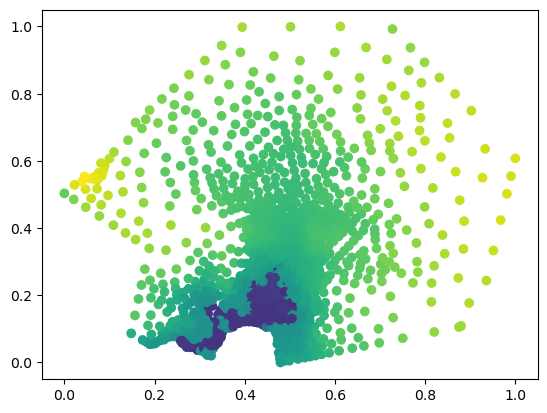

In [261]:
plt.scatter(train_list[0].x[:,0], train_list[0].x[:,1], c = train_list[4].y[:,5])

In [162]:
p1

0.999000499833375

In [148]:
import torch
from torch.nn.functional import normalize

# define a torch tensor
t = torch.tensor([1., 2., 3., -2., -5.])

# print the above tensor
print("Tensor:", t)

# normalize the tensor
t1 = normalize(t, p=1.0, dim = 0)
t2 = normalize(t, p=2.0, dim = 0)

# print normalized tensor
print("Normalized tensor with p=1:", t1)
print("Normalized tensor with p=2:", t2)

Tensor: tensor([ 1.,  2.,  3., -2., -5.])
Normalized tensor with p=1: tensor([ 0.0769,  0.1538,  0.2308, -0.1538, -0.3846])
Normalized tensor with p=2: tensor([ 0.1525,  0.3050,  0.4575, -0.3050, -0.7625])


In [153]:
nodes = data.x
coors = data.x[:, :2]

In [154]:
n_nodes = nodes.shape[0]
edges = torch.zeros([1, n_nodes, n_nodes, 1])
for i in tqdm(range(0, n_nodes)):
    for j in range(0, n_nodes):
        if i != j:
            d = ((coors[i, 0] - coors[j, 0])**2 + (coors[i, 1] - coors[j, 1])**2)**0.5
            edges[0, i, j, 0] = 1/d

 44%|████████████████████████████████▊                                         | 494/1112 [01:15<01:34,  6.54it/s]


KeyboardInterrupt: 

In [177]:
def make_all_connection(nodes, coors):
    n_nodes = nodes.shape[0]
    edges = torch.zeros([1, n_nodes, n_nodes, 1])
    for i in tqdm(range(0, n_nodes)):
        for j in range(0, n_nodes):
            if i != j:
                d = ((coors[i, 0] - coors[j, 0])**2 + (coors[i, 1] - coors[j, 1])**2)**0.5
                edges[0, i, j, 0] = d
    return edges
            

val_list = torch.load(f'../Grid_graph_val_data.pt')
train_list = torch.load(f'../Grid_graph_train_data.pt')

data = train_list[0]
edges = make_all_connection(data.x, data.x[:, :2])
print("Edges created")

100%|█████████████████████████████████████████████████████████████████████████| 1112/1112 [02:06<00:00,  8.78it/s]


Edges created


100%|██████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 23025.38it/s]


In [197]:
torch.zeros([len(train_list), train_list[0].x.shape[0], train_list[0].x.shape[1]]).shape

torch.Size([2520, 1112, 4])

In [199]:
train_list2 = {}
train_list2['x'] = torch.zeros([len(train_list), train_list[0].x.shape[0], train_list[0].x.shape[1]])
train_list2['coors'] = torch.zeros([len(train_list), train_list[0].x.shape[0], 2])
train_list2['y'] = torch.zeros([len(train_list), train_list[0].y.shape[0], train_list[0].y.shape[1]])
train_list2['edges'] = edges

val_list2 = {}
val_list2['x'] = torch.zeros([len(val_list), val_list[0].x.shape[0], val_list[0].x.shape[1]])
val_list2['coors'] = torch.zeros([len(val_list), val_list[0].x.shape[0], 2])
val_list2['y'] = torch.zeros([len(val_list), val_list[0].y.shape[0], val_list[0].y.shape[1]])
val_list2['edges'] = edges

for i in tqdm(range(0, len(train_list))):
    data = train_list[i]
    train_list2['x'][i] = data.x[:]
    train_list2['coors'][i] = data.x[:, :2]
    train_list2['y'][i] = data.y[:]
    # dic['edge_weight'] = data.edge_weight 

for i in tqdm(range(0, len(val_list))):
    data = train_list[i]
    val_list2['x'][i] = data.x[:]
    val_list2['coors'][i] = data.x[:, :2]
    val_list2['y'][i] = data.y[:]
    
torch.save(train_list2, f'../data/Graph_y20_train_data.pt')
torch.save(val_list2, f'../data/Graph_y20_val_data.pt')

100%|██████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 12515.12it/s]


In [201]:
train_list2['x'].shape

torch.Size([2520, 1112, 4])

In [140]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    train_list[1],
    num_neighbors=[25, 10],
    batch_size=16,
    num_workers=1,
)

In [281]:
import torch
from egnn_pytorch import EGNN_Network

net = EGNN_Network(
    num_tokens = 21,
    num_positions = 1024,           # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 32,
    depth = 3,
    num_nearest_neighbors = 8,
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)

feats = torch.randint(0, 21, (1, 1024)) # (1, 1024)
coors = torch.randn(1, 1024, 3)         # (1, 1024, 3)
mask = torch.ones_like(feats).bool()    # (1, 1024)

feats_out, coors_out = net(feats, coors, mask = mask)

In [277]:
edges.shape

torch.Size([1, 1112, 1112, 1])

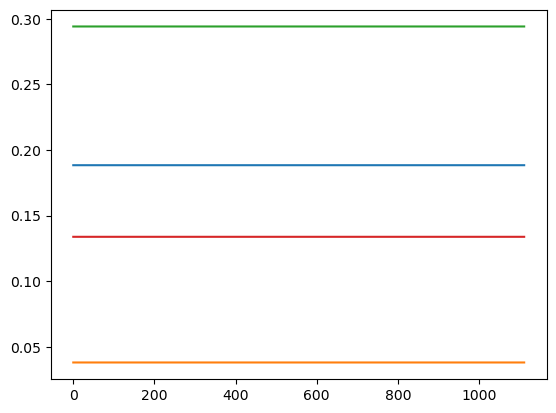

In [233]:
plt.plot(abs(feats1-feats)[0].detach().numpy())

In [263]:
scaling = [1, 5000, 5000, 5000, 4000]
# y_pred = np.zeros([len(val_list), 1112, 5])
# y_true = np.zeros([len(val_list), 1112, 5])
count = 0
for k in tqdm(range(0, len(val_list))):
    data = val_list[k]
    # prd = net(data.x.to(torch.float).to(device), data.edge_index.to(device)).to('cpu').detach().numpy()
    # tru = data.y.to('cpu').detach().numpy()
    # for i in range(0, prd.shape[1]):
    #     prd[:, i] = prd[:, i]*scaling[i]
    #     tru[:, i] = tru[:, i]*scaling[i]
    # y_pred[k] = prd
    # y_true[k] = tru
    # count += 1
    
# result_file = "../results/test_torch_egcn_nophy_gpu.pkl"

# with open(result_file, 'rb') as file:
#     [rates, years, y_true0, y_pred0] = pickle.load(file)  

100%|██████████████████████████████████████████████████████████████████████| 1920/1920 [00:00<00:00, 1911933.45it/s]


In [264]:
xc = data.x[:,0].to('cpu').detach().numpy()
yc = data.x[:,1].to('cpu').detach().numpy()

In [65]:
rmse_rate = np.zeros([y_true0.shape[2], len(np.unique(rates))])
for i, r in enumerate(np.unique(rates)):
    idx = (rates==r)
    y_true = y_true0[idx]
    y_pred = y_pred0[idx]
    
    for c in range(0, y_true0.shape[2]):
        rmse_rate[c, i] = RMSE(y_true[:, :, c], y_pred[:, :, c])
        
rmse_year = np.zeros([y_true0.shape[2], len(np.unique(years))])
for i, y in enumerate(np.unique(years)):
    idx = (years==y) & (rates*100%10==0)
    y_true = y_true0[idx]
    y_pred = y_pred0[idx]
    
    for c in range(0, y_true0.shape[2]):
        rmse_year[c, i] = RMSE(y_true[:, :, c], y_pred[:, :, c])

test_rates = [0.0, 0.2, 0.4, 0.6]
rmse_all = np.zeros([y_true0.shape[2], len(test_rates), 240])
for i, r in enumerate(test_rates):
    for j, y in enumerate(np.unique(years)):
        
        idx = (rates==r) & (years==y)
        y_true = y_true0[idx]
        y_pred = y_pred0[idx]

        for c in range(0, y_true0.shape[2]):
            rmse_all[c, i, j] = RMSE(y_true[:, :, c], y_pred[:, :, c])
    

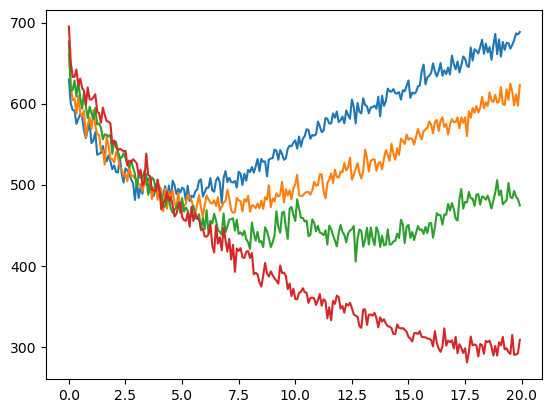

In [69]:
for i in range(0, 4):
    plt.plot(np.unique(years), rmse_all[3, i, :])

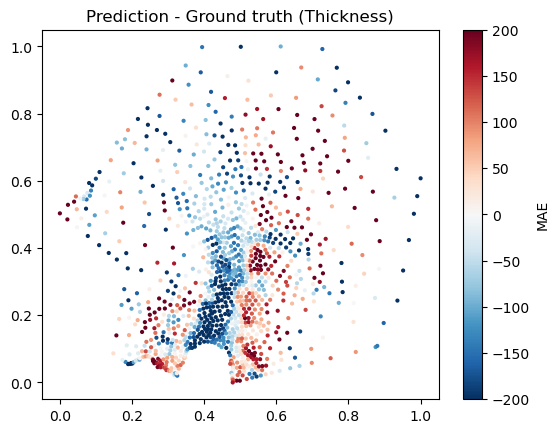

In [75]:
ind = 10
c = 4

channels = ["SMB", "U velocity", "V velocity", "Velocity", "Thickness"]
vmax = [1, 400, 400, 4000, 2000]
vmin = [0, -400, -400, 0, 0]

err = np.mean((y_pred0 - y_true0), axis=0)
plt.title(f"Prediction - Ground truth ({channels[c]})")
plt.scatter(xc, yc, c = err[:, c], s = 4, cmap = "RdBu_r", vmin = -200, vmax = 200)
plt.colorbar(label = "MAE")

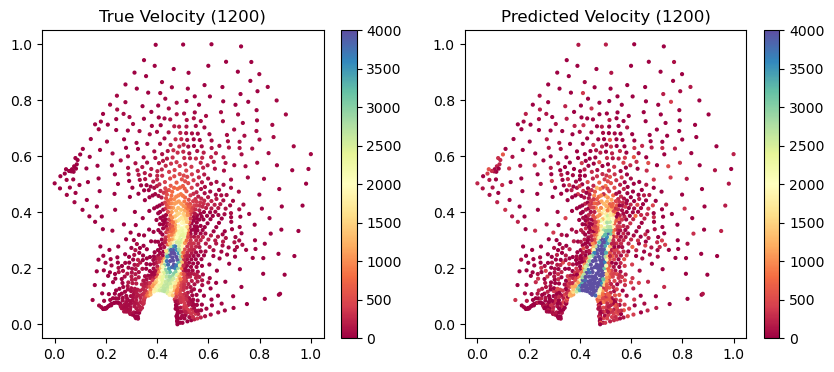

In [76]:
ind = 1200
c = 3
err = np.mean(abs(y_pred - y_true), axis=0)


fig, ax = plt.subplots(1,2, figsize = (10,4))
c1 = ax[0].scatter(xc, yc, c = y_true0[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[0].set_title(f"True {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[0])
c2 = ax[1].scatter(xc, yc, c = y_pred0[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[1].set_title(f"Predicted {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[1])

## GCN results

In [3]:
val_list = torch.load(f'../data/Grid_graph_val_data.pt')
train_list = torch.load(f'../data/Grid_graph_train_data.pt')

xc = val_list[0].x[:, 0]
yc = val_list[0].x[:, 1]

In [34]:
for i in range(0, len(train_list)):
    train_list[i].y = train_list[i].y[:, [1,2,4]]

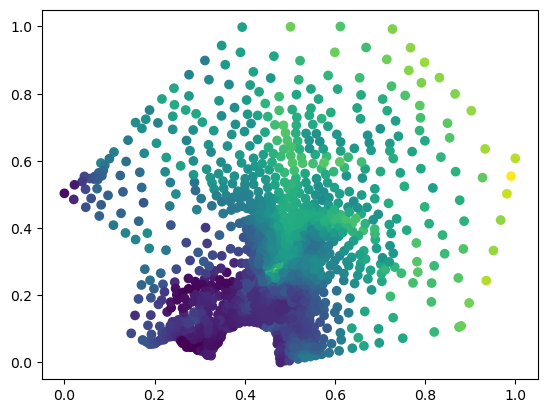

In [35]:
plt.scatter(xc, yc, c = train_list[0].y[:, 2])

In [5]:
scaling = [1, 5000, 5000, 5000, 4000]
# y_pred = np.zeros([len(val_list), 1112, 5])
# y_true = np.zeros([len(val_list), 1112, 5])
count = 0
for k in tqdm(range(0, len(val_list))):
    data = val_list[k]
    # prd = net(data.x.to(torch.float).to(device), data.edge_index.to(device)).to('cpu').detach().numpy()
    # tru = data.y.to('cpu').detach().numpy()
    # for i in range(0, prd.shape[1]):
    #     prd[:, i] = prd[:, i]*scaling[i]
    #     tru[:, i] = tru[:, i]*scaling[i]
    # y_pred[k] = prd
    # y_true[k] = tru
    # count += 1

model_type = ["egcn", "gcn", "fcn"]
result_file = "../results/test_torch_gcn_lr0.001_nophy_gpu.pkl"

with open(result_file, 'rb') as file:
    [rates, years, y_true0, y_pred0] = pickle.load(file)  

100%|██████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<?, ?it/s]


In [350]:
vel = np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)
a = np.append(y_true0, vel, axis = 2)
a.shape

(1920, 1112, 4)

In [349]:
np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)

(1920, 1112, 1)

In [36]:
def add_vel(y_true0):
    vel = np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)
    y_true0 = np.append(y_true0, vel, axis = 2)
    return y_true0
    
model_types = ["fcn", "mlp", "gcn", "gat", "egcn"] #["fcn", "mlp", "gcn", "gat", "egcn"]
test_rates = [0.0, 0.2, 0.4, 0.6]
rmse_all = {}
mean_all = {}
std_all = {}
r_all = {}

ch = 3
if ch == 3:
    scaling = np.array([5000, 5000, 4000, 5000])
elif ch == 5:
    scaling = [5000, 5000, 5000, 4000, 3000]
elif ch == 6:
    scaling = [1, 5000, 5000, 5000, 4000, 3000]

rmse_df = {}
rmse_std = {}
r_df = {}
mean_df = {}

for grid in [1112]: # [526, 2468, 1112]:
    
    for model_type in model_types:
        if model_type == "fcn":
            result_file = f"../results/test_torch_dgl_{model_type}_{grid}_lr0.001_nophy_ch{ch}.pkl"
        else:
            result_file = f"../results/test_torch_dgl_{model_type}_{grid}_lr0.01_nophy_ch{ch}.pkl"
        with open(result_file, 'rb') as file:
            [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
            if ch == 3:
                y_true0 = add_vel(y_true0) * scaling
                y_pred0 = add_vel(y_pred0) * scaling
            elif ch >= 5:
                y_true0 = y_true0 * scaling
                y_pred0 = y_pred0 * scaling

        test_rates = np.unique(rates)
        test_years = np.unique(years)

        rmse_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        std_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all["true"] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        std_all["true"] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        r_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        for i, r in enumerate(test_rates):
            for j, y in enumerate(test_years):

                idx = (rates==r) & (years==y)

                y_true = y_true0[idx]
                y_pred = y_pred0[idx]

                for c in range(0, y_true0.shape[2]):
                    rmse_all[model_type][c, i, j] = RMSE(y_true[:, :, c], y_pred[:, :, c])         
                    r_all[model_type][c, i, j] = corr(y_true[:, :, c], y_pred[:, :, c])
                    mean_all["true"][c, i, j] = np.mean(y_true[:, :, c])  
                    mean_all[model_type][c, i, j] = np.mean(y_pred[:, :, c])    
                    std_all["true"][c, i, j] = np.std(y_true[:, :, c])  
                    std_all[model_type][c, i, j] = np.std(y_pred[:, :, c])    
        print(result_file)

        rmse_df[str(grid)] = pd.DataFrame()
        r_df[str(grid)] = pd.DataFrame()
        rmse_std[str(grid)] = pd.DataFrame()
        mean_df[str(grid)] = pd.DataFrame()
        
        for i in range(0, 4):
            mean_df[str(grid)].loc[i, "true"] = np.mean(mean_all["true"][i])
            for v in rmse_all.keys():
                rmse_df[str(grid)].loc[i, v] = np.mean(rmse_all[v][i])
                rmse_std[str(grid)].loc[i, v] = np.std(rmse_all[v][i])
                r_df[str(grid)].loc[i, v] = np.mean(r_all[v][i])
                mean_df[str(grid)].loc[i, v] = np.mean(mean_all[v][i])
                
print("DONE!")

../results/test_torch_dgl_fcn_1112_lr0.001_nophy_ch3.pkl
../results/test_torch_dgl_mlp_1112_lr0.01_nophy_ch3.pkl
../results/test_torch_dgl_gcn_1112_lr0.01_nophy_ch3.pkl
../results/test_torch_dgl_gat_1112_lr0.01_nophy_ch3.pkl
../results/test_torch_dgl_egcn_1112_lr0.01_nophy_ch3.pkl
DONE!


In [48]:
y_pred0.shape

(960, 2468, 4)

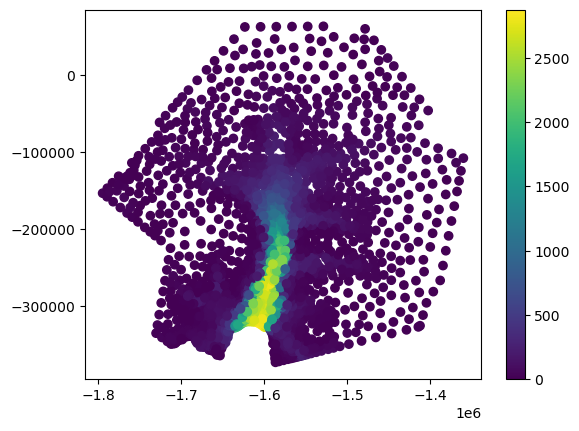

In [54]:
idx = 100
plt.scatter(xc[:, 0], yc[:, 0], c = y_true0[idx, :, 2])
plt.colorbar()

In [65]:
with open(f'../data/CNN_dataset_g{20000}.pkl', 'rb') as file:
    [grid_input, grid_output, train_index] = pickle.load(file)
    

In [78]:
xx = grid_input[0, 0]
yy = grid_input[0, 1]

In [69]:
val_graphs = load_graphs(f"../data/DGL_val_dataset_g{20000}.bin")[0]
xc = val_graphs[0].ndata['feat'][:, 0]
yc = val_graphs[0].ndata['feat'][:, 1]



In [102]:
filename = f'D:\\ISSM\\version2\\transient_g{20000}_y20_r*.mat'
files = glob.glob(filename)
first = True

for filename in files[:1]:
    print(filename)

    rate = float(filename[-7:-4])

    test = sio.loadmat(filename)

    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    # Interpolate points to images
    gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 2000), np.arange(yc.min(), yc.max(), 2000))

D:\ISSM\version2\transient_g20000_y20_r000.mat


In [101]:
gridx.shape

(1, 1)

In [107]:
value = grid_output[0, 3]
xx[np.isnan(xx)] = 0
yy[np.isnan(yy)] = 0

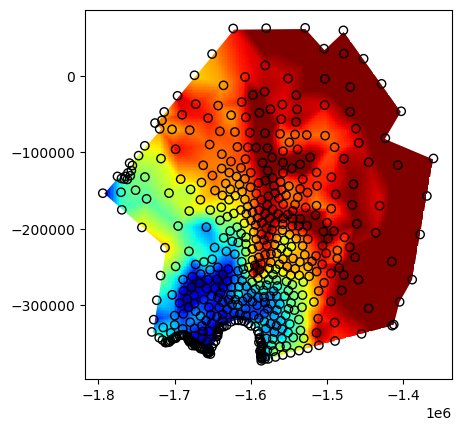

In [132]:
c = 3

fig, ax = plt.subplots(1,1)
scaling = [5000, 5000, 4000, 3000]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 0]
value = grid_output[0, c] * 4000
plt.pcolormesh(gridx, gridy, value, cmap = "jet", vmin=vmin[c], vmax=2000)
outpolygon.plot(ax=ax, color="white",edgecolor="white")
plt.scatter(xc[:], yc[:], edgecolor = "k", facecolors='none') #y_true0[idx, :, 2])

# plt.colorbar()

2468


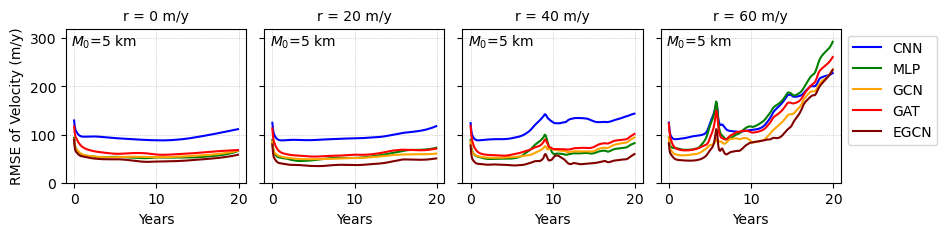

In [189]:
## Channel 3
print(grid)
scaling = [5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 0]
verr = [200, 200, 100, 320]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
["fcn", "mlp", "gcn", "gat", "egcn"]
colors = ["blue", "green", "orange", "red", "maroon", "k"]
meshsize = {526: 20, 1112: 10, 2468: 5}
model_types = ["gcn", "fcn"]

c = 3
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        if model_type == "fcn":
            ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"CNN")
        else:
            ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        if grid == 2468:
            ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
        ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
        if m == 0:
            ax[ci].annotate(f"$M_{0}$={meshsize[grid]} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")


2468


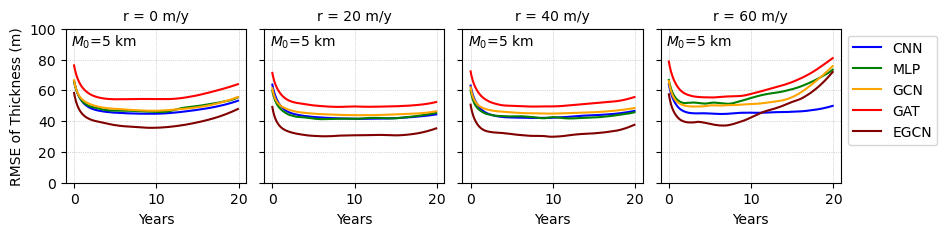

In [190]:
## Channel 3
print(grid)

cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
colors = ["blue", "green", "orange", "red", "maroon", "k"]
model_types = ["gcn", "fcn"]

c = 2
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        if model_type == "fcn":
            ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"CNN")
        else:
            ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        if grid == 2468:
            ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
        ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
        if m == 0:
            ax[ci].annotate(f"$M_{0}$={meshsize[grid]} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")

1112


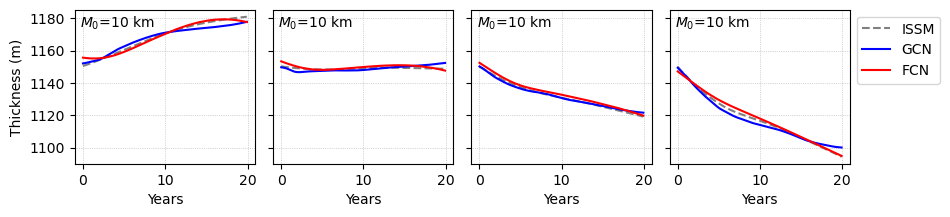

In [38]:
## Channel 3
print(grid)
scaling = [5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 0]
verr = [200, 200, 100, 320]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
colors = ["blue", "red", "red", "maroon", "k"]
meshsize = {526: 20, 1112: 10, 2468: 5}
model_types = ["gcn", "fcn"]

c = 2
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for ci, i in enumerate(test_rates):
    ax[ci].plot(np.unique(years), mean_all["true"][c, ci, :], color = "gray", ls="--", label=f"ISSM")
    for m, model_type in enumerate(model_types):    
        # ax[ci].fill_between(np.unique(years), mean_all[model_type][c, ci, :]+std_all[model_type][c, ci, :], 
        #                     mean_all[model_type][c, ci, :]-std_all[model_type][c, ci, :], alpha = 0.1, color = colors[m])
        ax[ci].plot(np.unique(years), mean_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        if grid == 2468:
            ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
        # ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
        if m == 0:
            ax[ci].annotate(f"$M_{0}$={meshsize[grid]} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    
ax[0].set_ylabel("" + channels[c])
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")

In [16]:
std_all

NameError: name 'std_all' is not defined

## Channel 5 analysis

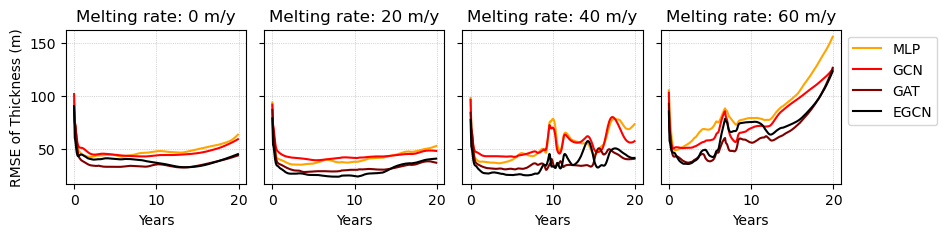

In [265]:
## Channel 5
scaling = [5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 5000, 2000, 3000]
vmin = [-5000, -5000, 0, 0, -3000]
verr = [200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]
colors = ["orange", "red", "maroon", "k"]

c = 3
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        ax[ci].set_title(f"Melting rate: {int(i*100)} m/y")
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1))


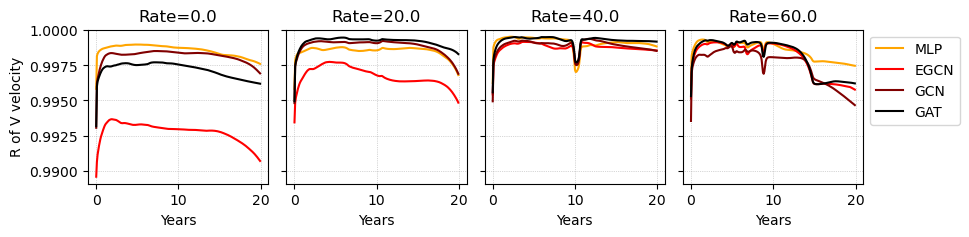

In [175]:
## Channel 5
scaling = [5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 5000, 2000, 3000]
vmin = [-5000, -5000, 0, 0, -3000]
verr = [200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["SMB", "U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]
colors = ["orange", "red", "maroon", "k"]

c = 2
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), r_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        ax[ci].set_title(f"Rate={np.round(i*100)}")
    
ax[0].set_ylabel("R of " + channels[c])
plt.legend(bbox_to_anchor=(1,1))


In [178]:
rmse_df[''] = pd.DataFrame()
r_df = pd.DataFrame()

for i in range(0, 5):
    for v in rmse_all.keys():
        rmse_df.loc[i, v] = np.mean(rmse_all[v][i])
        r_df.loc[i, v] = np.mean(r_all[v][i])
# rmse_all['mlp'].shape

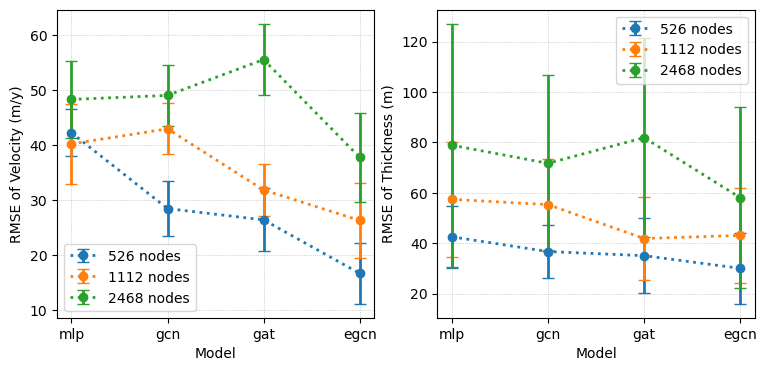

In [260]:
# plt.plot(rmse_df['2468'].keys(), rmse_df['2468'].loc[3, :], '.')
channels = ["U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]
fig, ax = plt.subplots(1,2,figsize = (9,4))
for i, c in enumerate([2,3]):
    for grid in ['526', '1112', '2468']:
        if grid == '526':
            label = f"{grid} nodes"
        if grid == '1112':
            label = f"{grid} nodes"
        if grid == '2468':
            label = f"{grid} nodes"
        ax[i].errorbar(rmse_df[grid].keys(), rmse_df[grid].loc[c, :], rmse_std[grid].loc[c, :], ls = ":", fmt='o', lw=2, capsize = 4, label = label)
    ax[i].set_xlabel("Model")
    ax[i].set_ylabel(f"RMSE of {channels[c]}")
    ax[i].grid(ls = ":", lw = 0.5)
    ax[i].legend()
# plt.bar(rmse_df['1112'].keys(), rmse_df['1112'].loc[3, :])
# plt.bar(rmse_df['526'].keys(), rmse_df['526'].loc[3, :])

In [173]:
rmse_df['2468'][2:4]

fcn        mlp        gcn        gat       egcn
2   45.392656  48.309543  49.048024  55.571363  37.767041
3  111.781014  78.861797  71.699280  81.878131  58.080175

In [174]:
r_df['2468'][2:4]

fcn       mlp       gcn       gat      egcn
2  0.997589  0.997271  0.997187  0.996383  0.998330
3  0.995577  0.997750  0.998131  0.997571  0.998733

In [145]:
np.mean(rmse_all['egcn'], axis = (1,2))[3:5]

array([0.0128637 , 0.01611608])

In [146]:
np.mean(r_all['egcn'], axis = (1,2))[3:5]

array([0.99689684, 0.9970997 ])

## Draw error maps (image)

In [29]:
# Variable: Path to .exp file
text = "D:\\ISSM\\DomainOutline.exp"

# Process: Open .exp file for reading
file = open(text, 'r')

# Process: Read first line of .exp file
line = file.readline()
print(line)
# # Process: Decode line
# .exp = line.decode('utf-16', 'ignore')

# # Message: Return message to display
# print exp

# Process: Close file object
file.close()



## Name:



In [30]:
with open(text, 'r') as f:
    t = f.readlines()

df = pd.DataFrame()

for i, x in enumerate(t[5:-1]):
    
    df.loc[i, "X"] = float(x.split()[0])
    df.loc[i, "Y"] = float(x.split()[1])
    # print(x)

In [31]:
from shapely.geometry import Point, LineString, shape

#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)


In [32]:
## Create outside cilp polygon
from shapely.geometry import box

gdf['shape_id'] = 0
polygon = gdf.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

outpolygon = geopandas.GeoSeries(
    [
        box(*box(*polygon.total_bounds).buffer(2000).bounds).difference(
            polygon["geometry"].values[0]
        )
    ],
    crs=polygon.crs,
)

In [7]:
### Channel 3 ###

for r in [test_rates[0], test_rates[1], test_rates[2], test_rates[3]]:
    for grid in [5000, 10000, 20000]:

        for model_type in ["fcn"]: #["mlp", "gcn", "gat", "egcn"]:
            files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

            filename = files[0]
            test = sio.loadmat(filename)

            xc = test['S'][0][0][0]
            yc = test['S'][0][0][1]

            n_nodes = xc.shape[0]

            if model_type == "fcn":
                result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.001_nophy_ch3.pkl"
            else:
                result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch3.pkl"
            print(result_file)
            with open(result_file, 'rb') as file:
                [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
                y_true0 = add_vel(y_true0)
                y_pred0 = add_vel(y_pred0)

#                 r = test_rates[1]
#                 c = 3

            scaling = [5000, 5000, 4000, 5000]
            year_list = [0, 4, 8, 12, 16, 19]
            vmax = [5000, 5000, 3000, 5000]
            vmin = [-5000, -5000, 0, 0]
            verr = [200, 200, 100, 200]
            cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
            channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]

            for c in [2,3]:

                fig, ax = plt.subplots(3, len(year_list), figsize = (len(year_list)*2, 6), dpi = 100,
                                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
                plt.subplots_adjust(hspace=0.05, wspace=0.05)

                for j, y in enumerate(year_list):

                    idx = (rates==r) & (years==y)

                    # Interpolate points to images
                    gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 1000), np.arange(yc.min(), yc.max(), 1000))
                    coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
                    value = (y_pred0[idx, :, c]*scaling[c])[0]
                    value0 = (y_true0[idx, :, c]*scaling[c])[0]

                    gridz = griddata(coord, value, (gridx, gridy), method='linear')    
                    gridz0 = griddata(coord, value0, (gridx, gridy), method='linear') 
                    
                    rmse_all[model_type][c, i, j] = RMSE(gridz, gridz0)         
                    r_all[model_type][c, i, j] = corr(gridz, gridz0)
                    mean_all["true"][c, i, j] = np.mean(gridz0)  
                    mean_all[model_type][c, i, j] = np.mean(gridz) 

                    obsmap = ax[0, j].pcolormesh(gridx, gridy, gridz0, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                    prdmap = ax[1, j].pcolormesh(gridx, gridy, gridz, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                    difmap = ax[2, j].pcolormesh(gridx, gridy, gridz - gridz0, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

                    outpolygon.plot(ax = ax[0, j], color="white",edgecolor="white")
                    outpolygon.plot(ax = ax[1, j], color="white",edgecolor="white")
                    outpolygon.plot(ax = ax[2, j], color="white",edgecolor="white")

                    ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                    ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                    ax[2, j].annotate(f"Diff", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')

                    ax[0, j].set_title(f"{channels[c]}\n(y={y}, r={int(r*100)})", fontsize = 10)

                    # fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                    # fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                    # fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)

                plt.savefig(f"D:\\ISSM\\Figures\\Map_c{c}_{n_nodes}_{model_type}_r{int(np.round(r*100))}.png", bbox_inches = "tight")
                plt.close()

../results/test_torch_dgl_fcn_2468_lr0.01_nophy_ch3.pkl


FileNotFoundError: [Errno 2] No such file or directory: '../results/test_torch_dgl_fcn_2468_lr0.01_nophy_ch3.pkl'

## GNN & MLP maps

In [145]:
### Channel 3 ###

rmse_all = {}
r_all = {}
mean_all = {}
sum_all = {}


for grid in [5000, 10000, 20000]:

    for model_type in ["mlp", "gcn", "gat", "egcn"]:

        files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

        filename = files[0]
        test = sio.loadmat(filename)

        xc = test['S'][0][0][0]
        yc = test['S'][0][0][1]

        n_nodes = xc.shape[0]

        result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch3.pkl"
        print(result_file)
        with open(result_file, 'rb') as file:
            [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
            y_true0 = add_vel(y_true0)
            y_pred0 = add_vel(y_pred0)

        scaling = [5000, 5000, 4000, 5000]
        year_list = [0, 4, 8, 12, 16, 19]
        vmax = [5000, 5000, 3000, 5000]
        vmin = [-5000, -5000, 0, 0]
        verr = [100, 100, 80, 100]
        cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
        channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]
        
        rmse_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        r_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])

        for c in [2, 3]:

            fig, ax = plt.subplots(3, len(test_rates), figsize = (len(test_rates)*2, 6), dpi = 100,
                                   subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
            plt.subplots_adjust(hspace=0.05, wspace=0.05)

            for j, r in enumerate(test_rates):

                idx = (rates==r)

                # Interpolate points to images
                gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 1000), np.arange(yc.min(), yc.max(), 1000))
                coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
                value = np.mean(y_pred0[idx, :, c]*scaling[c], axis = 0)
                value0 = np.mean(y_true0[idx, :, c]*scaling[c], axis = 0)

                gridz = griddata(coord, value, (gridx, gridy), method='linear')    
                gridz0 = griddata(coord, value0, (gridx, gridy), method='linear')
                
                rmse_all[model_type + str(grid)][c, j, i] = RMSE(gridz, gridz0)         
                r_all[model_type + str(grid)][c, j, i] = corr(gridz, gridz0)
                mean_all["true" + str(grid)][c, j, i] = np.mean(gridz0)  
                mean_all[model_type + str(grid)][c, j, i] = np.mean(gridz)
                sum_all["true" + str(grid)][c, j, i] = np.sum(gridz0)  
                sum_all[model_type + str(grid)][c, j, i] = np.sum(gridz) 

                obsmap = ax[0, j].pcolormesh(gridx, gridy, gridz0, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                prdmap = ax[1, j].pcolormesh(gridx, gridy, gridz, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                difmap = ax[2, j].pcolormesh(gridx, gridy, gridz - gridz0, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

                outpolygon.plot(ax = ax[0, j], color="white",edgecolor="white")
                outpolygon.plot(ax = ax[1, j], color="white",edgecolor="white")
                outpolygon.plot(ax = ax[2, j], color="white",edgecolor="white")

                ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                ax[2, j].annotate(f"{model_type.upper()}-True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')

                ax[0, j].set_title(f"{channels[c]}\n(r={int(r*100)})", fontsize = 10)

                # fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                # fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                # fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)

            plt.savefig(f"D:\\ISSM\\Figures\\Map_c{c}_{n_nodes}_{model_type}_rall.png", bbox_inches = "tight")
            # plt.close()

../results/test_torch_dgl_mlp_2468_lr0.01_nophy_ch3.pkl



KeyboardInterrupt



Error in callback <function flush_figures at 0x000001CA13083A30> (for post_execute):



KeyboardInterrupt



## CNN result maps

../results/test_torch_dgl_fcn_2468_lr0.001_nophy_ch3.pkl
../results/test_torch_dgl_fcn_1112_lr0.001_nophy_ch3.pkl
../results/test_torch_dgl_fcn_526_lr0.001_nophy_ch3.pkl


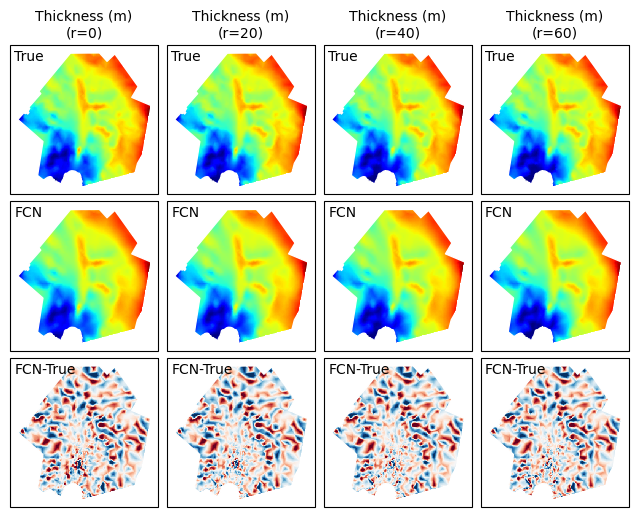

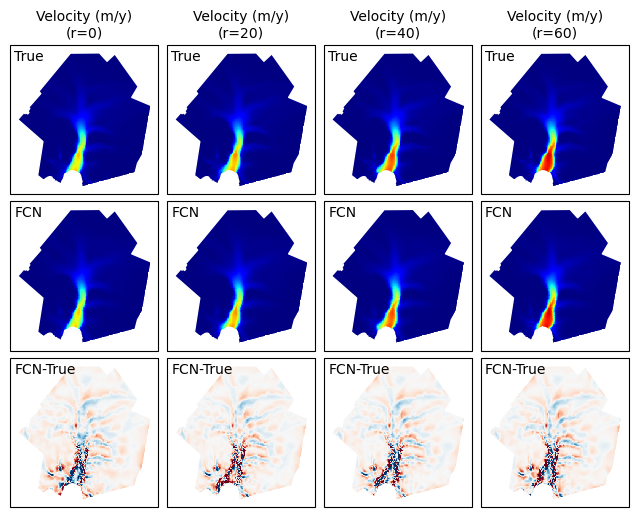

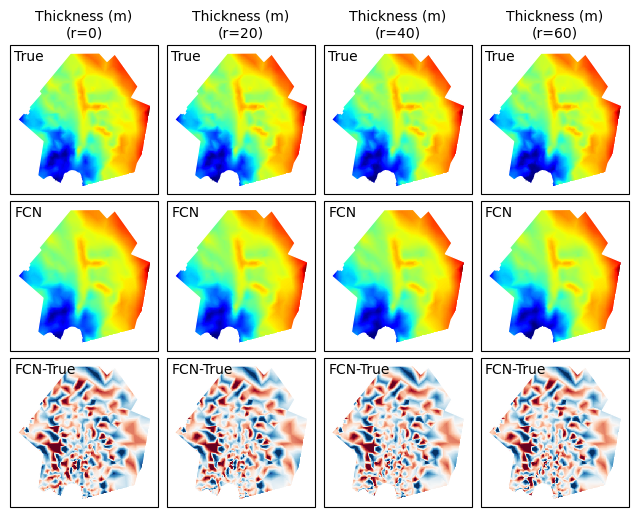

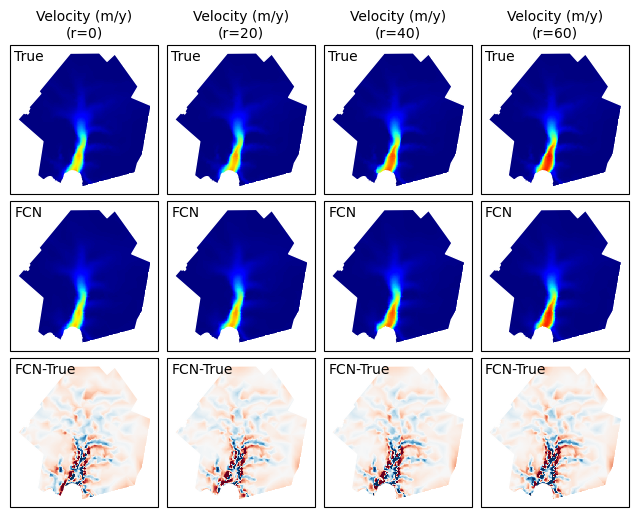

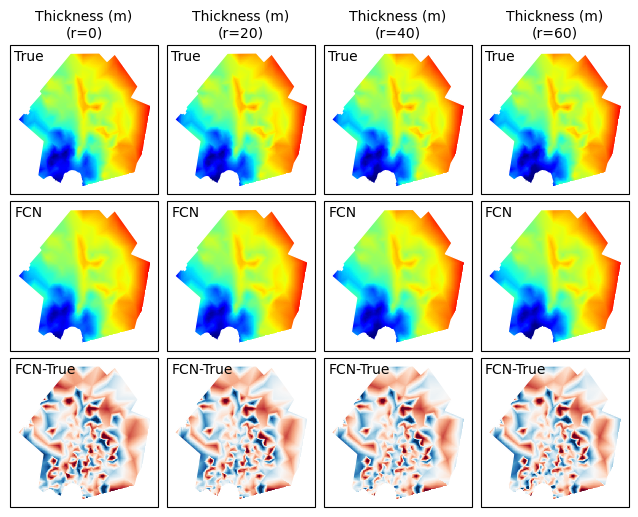

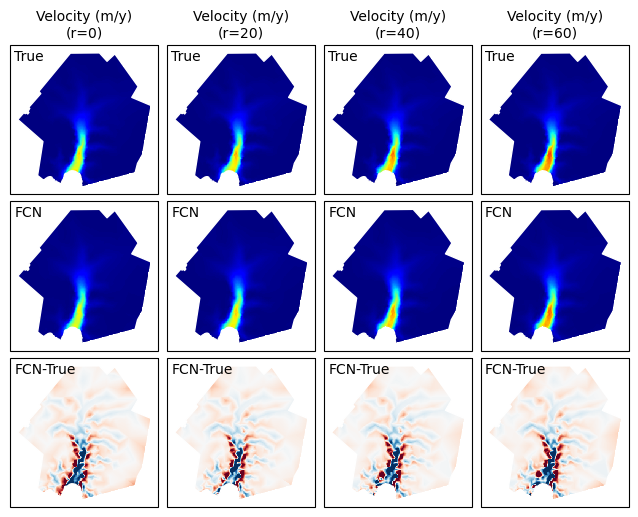

In [35]:
### Channel 3 ###

rmse_all = {}
r_all = {}
mean_all = {}
sum_all = {}


for grid in [5000, 10000, 20000]:

    for model_type in ["fcn"]:

        files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

        filename = files[0]
        test = sio.loadmat(filename)

        xc = test['S'][0][0][0]
        yc = test['S'][0][0][1]

        n_nodes = xc.shape[0]

        result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.001_nophy_ch3.pkl"
        print(result_file)
        with open(result_file, 'rb') as file:
            [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
            y_true0 = add_vel(y_true0)
            y_pred0 = add_vel(y_pred0)

        scaling = [5000, 5000, 4000, 5000]
        year_list = [0, 4, 8, 12, 16, 19]
        vmax = [5000, 5000, 3000, 5000]
        vmin = [-5000, -5000, 0, 0]
        verr = [100, 100, 80, 100]
        cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
        channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]
        
        rmse_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        r_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])

        for c in [2, 3]:

            fig, ax = plt.subplots(3, len(test_rates), figsize = (len(test_rates)*2, 6), dpi = 100,
                                   subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
            plt.subplots_adjust(hspace=0.05, wspace=0.05)

            for j, r in enumerate(test_rates):

                idx = (rates==r)

                # Interpolate points to images
                gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 2000), np.arange(yc.min(), yc.max(), 2000))
                coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
                value = np.mean(y_pred0[idx, :, c]*scaling[c], axis = 0)
                value0 = np.mean(y_true0[idx, :, c]*scaling[c], axis = 0)

                gridz = griddata(coord, value, (gridx, gridy), method='linear')    
                gridz0 = griddata(coord, value0, (gridx, gridy), method='linear')
                
                # rmse_all[model_type + str(grid)][c, j, i] = RMSE(gridz, gridz0)         
                # r_all[model_type + str(grid)][c, j, i] = corr(gridz, gridz0)
                # mean_all["true" + str(grid)][c, j, i] = np.mean(gridz0)  
                # mean_all[model_type + str(grid)][c, j, i] = np.mean(gridz)
                # sum_all["true" + str(grid)][c, j, i] = np.sum(gridz0)  
                # sum_all[model_type + str(grid)][c, j, i] = np.sum(gridz) 

                obsmap = ax[0, j].pcolormesh(gridx, gridy, gridz0, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                prdmap = ax[1, j].pcolormesh(gridx, gridy, gridz, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
                difmap = ax[2, j].pcolormesh(gridx, gridy, gridz - gridz0, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

                outpolygon.plot(ax = ax[0, j], color="white",edgecolor="white")
                outpolygon.plot(ax = ax[1, j], color="white",edgecolor="white")
                outpolygon.plot(ax = ax[2, j], color="white",edgecolor="white")

                ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                ax[1, j].annotate(f"FCN", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
                ax[2, j].annotate(f"FCN-True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')

                ax[0, j].set_title(f"{channels[c]}\n(r={int(r*100)})", fontsize = 10)

                # fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                # fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
                # fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)

            plt.savefig(f"D:\\ISSM\\Figures\\Map_c{c}_{n_nodes}_{model_type}_rall.png", bbox_inches = "tight")
            # plt.close()

In [200]:
gridz0.shape

(219, 218)

In [203]:

rmse_all = {}
r_all = {}
mean_all = {}
sum_all = {}

test_years = np.unique(years)[::6]

for grid in [5000, 10000, 20000]:

    for model_type in ["fcn", "mlp", "gcn", "gat", "egcn"]:

        files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

        filename = files[0]
        test = sio.loadmat(filename)

        xc = test['S'][0][0][0]
        yc = test['S'][0][0][1]

        n_nodes = xc.shape[0]
        if model_type == "fcn":
            result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.001_nophy_ch3.pkl"
        else:
            result_file = f"../results/test_torch_dgl_{model_type}_{n_nodes}_lr0.01_nophy_ch3.pkl"
        print(result_file)
        with open(result_file, 'rb') as file:
            [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
            y_true0 = add_vel(y_true0)
            y_pred0 = add_vel(y_pred0)

        scaling = [5000, 5000, 4000, 5000]
        year_list = [0, 4, 8, 12, 16, 19]
        vmax = [5000, 5000, 3000, 5000]
        vmin = [-5000, -5000, 0, 0]
        verr = [100, 100, 80, 100]
        cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
        channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]
        
        rmse_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        r_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        mean_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all[model_type + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        sum_all["true" + str(grid)] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
        
        # Interpolate points to images
        gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 2000), np.arange(yc.min(), yc.max(), 2000))
        coord = np.array([xc[:, 0], yc[:, 0]]).transpose()        
            
        for i, r in tqdm(enumerate(test_rates)):
            for j, y in enumerate(test_years):

                idx = (rates==r) & (years==y)

                for c in [2, 3]:
                    
                    value = np.mean(y_pred0[idx, :, c]*scaling[c], axis = 0)
                    value0 = np.mean(y_true0[idx, :, c]*scaling[c], axis = 0)

                    gridz = griddata(coord, value, (gridx, gridy), method='linear')    
                    gridz0 = griddata(coord, value0, (gridx, gridy), method='linear')

                    rmse_all[model_type + str(grid)][c, i, j] = RMSE(gridz, gridz0)         
                    r_all[model_type + str(grid)][c, i, j] = corr(gridz, gridz0)
                    mean_all["true" + str(grid)][c, i, j] = np.nanmean(gridz0)  
                    mean_all[model_type + str(grid)][c, i, j] = np.nanmean(gridz)
                    sum_all["true" + str(grid)][c, i, j] = np.nansum(gridz0)  
                    sum_all[model_type + str(grid)][c, i, j] = np.nansum(gridz)

../results/test_torch_dgl_fcn_2468_lr0.001_nophy_ch3.pkl


4it [03:09, 47.41s/it]


../results/test_torch_dgl_mlp_2468_lr0.01_nophy_ch3.pkl


4it [03:04, 46.20s/it]


../results/test_torch_dgl_gcn_2468_lr0.01_nophy_ch3.pkl


4it [03:02, 45.73s/it]


../results/test_torch_dgl_gat_2468_lr0.01_nophy_ch3.pkl


4it [03:07, 46.89s/it]


../results/test_torch_dgl_egcn_2468_lr0.01_nophy_ch3.pkl


4it [03:03, 45.97s/it]


../results/test_torch_dgl_fcn_1112_lr0.001_nophy_ch3.pkl


4it [03:06, 46.70s/it]


../results/test_torch_dgl_mlp_1112_lr0.01_nophy_ch3.pkl


4it [03:03, 45.91s/it]


../results/test_torch_dgl_gcn_1112_lr0.01_nophy_ch3.pkl


4it [03:05, 46.29s/it]


../results/test_torch_dgl_gat_1112_lr0.01_nophy_ch3.pkl


4it [03:04, 46.18s/it]


../results/test_torch_dgl_egcn_1112_lr0.01_nophy_ch3.pkl


4it [03:04, 46.20s/it]


../results/test_torch_dgl_fcn_526_lr0.001_nophy_ch3.pkl


4it [00:16,  4.04s/it]


../results/test_torch_dgl_mlp_526_lr0.01_nophy_ch3.pkl


4it [00:16,  4.14s/it]


../results/test_torch_dgl_gcn_526_lr0.01_nophy_ch3.pkl


4it [00:16,  4.03s/it]


../results/test_torch_dgl_gat_526_lr0.01_nophy_ch3.pkl


4it [00:17,  4.29s/it]


../results/test_torch_dgl_egcn_526_lr0.01_nophy_ch3.pkl


4it [00:17,  4.38s/it]


5000
10000
20000


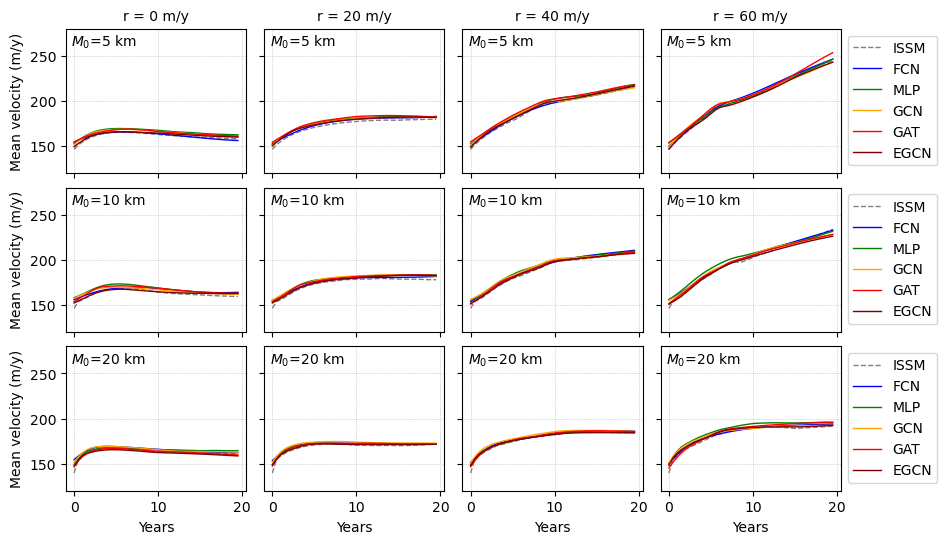

In [204]:
## Mean ice velocity
fig, ax = plt.subplots(3, len(test_rates), figsize = (len(test_rates)*2.5, 3*2), sharey = True, sharex = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
for gi, grid in enumerate([5000, 10000, 20000]):
    print(grid)
    scaling = [5000, 5000, 4000, 3000]
    year_list = [0, 3, 6, 9, 12, 15, 18]
    vmax = [5000, 5000, 2000, 5000]
    vmin = [-5000, -5000, 0, 0]
    verr = [200, 200, 100, 320]
    cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
    channels = ["U velocity", "V velocity", "Thickness (m)", "Mean velocity (m/y)", ]
    colors = ["blue", "green", "orange", "red", "maroon"]
    meshsize = {526: 20, 1112: 10, 2468: 5}

    c = 3    

    for ci, i in enumerate(test_rates):
        ax[gi, ci].plot(test_years, mean_all["true" + str(grid)][c, ci, :], color = "gray", ls="--", label=f"ISSM", lw=1)
        for m, model_type in enumerate(model_types):    
            ax[gi, ci].plot(test_years, mean_all[model_type + str(grid)][c, ci, :], color = colors[m], label=f"{model_type.upper()}", lw=1)
            ax[gi, ci].grid(ls = ":", lw=0.5)
            if gi == 2:
                ax[gi, ci].set_xlabel("Years")
            if grid == 5000:
                ax[gi, ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
            ylim1, ylim2 = ax[gi, ci].set_ylim(120, 280)
            if m == 0:
                ax[gi, ci].annotate(f"$M_{0}$={int(grid/1000)} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')

    
    ax[gi, 0].set_ylabel("" + channels[c])
    ax[gi, ci].legend(bbox_to_anchor=(1,1), loc = "upper left")

5000
10000
20000


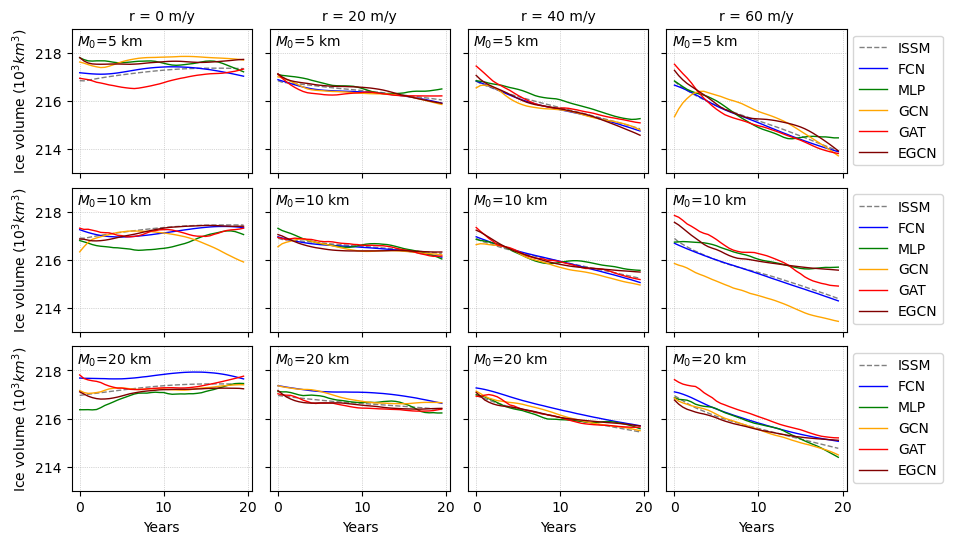

In [205]:
## Ice volume
fig, ax = plt.subplots(3, len(test_rates), figsize = (len(test_rates)*2.5, 3*2), sharey = True, sharex = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
for gi, grid in enumerate([5000, 10000, 20000]):
    print(grid)
    scaling = [1,1,2000*2000/(1000**3*1000),1]
    year_list = [0, 3, 6, 9, 12, 15, 18]
    vmax = [5000, 5000, 2000, 5000]
    vmin = [-5000, -5000, 0, 0]
    verr = [200, 200, 100, 320]
    cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
    channels = ["U velocity", "V velocity", "Ice volume ($10^3 km^3$)", "Velocity (m/y)", ]
    colors = ["blue", "green", "orange", "red", "maroon"]
    meshsize = {526: 20, 1112: 10, 2468: 5}

    c = 2

    for ci, i in enumerate(test_rates):
        ax[gi, ci].plot(test_years, sum_all["true" + str(grid)][c, ci, :]*scaling[c], color = "gray", ls="--", label=f"ISSM", lw=1)
        for m, model_type in enumerate(model_types):    
            ax[gi, ci].plot(test_years, sum_all[model_type + str(grid)][c, ci, :]*scaling[c], color = colors[m], label=f"{model_type.upper()}", lw=1)
            ax[gi, ci].grid(ls = ":", lw=0.5)
            if gi == 2:
                ax[gi, ci].set_xlabel("Years")
            if grid == 5000:
                ax[gi, ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
            ylim1, ylim2 = ax[gi, ci].set_ylim(213, 219)
            if m == 0:
                ax[gi, ci].annotate(f"$M_{0}$={int(grid/1000)} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')

    
    ax[gi, 0].set_ylabel("" + channels[c])
    ax[gi, ci].legend(bbox_to_anchor=(1,1), loc = "upper left")

5000


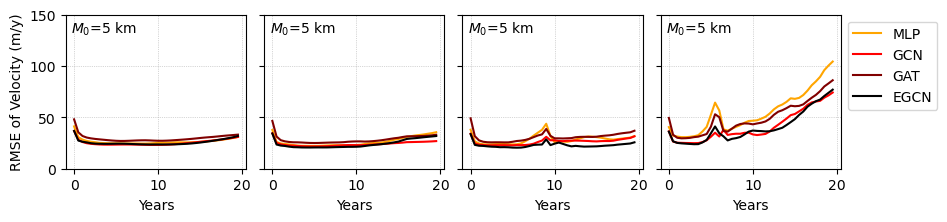

In [212]:
## Channel 3
grid = 5000
print(grid)
scaling = [5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 0]
verr = [200, 200, 100, 150]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
colors = ["orange", "red", "maroon", "k"]
meshsize = {526: 20, 1112: 10, 2468: 5}

c = 3
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(test_years, rmse_all[model_type+ str(grid)][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        if grid == 2468:
            ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
        ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
        if m == 0:
            ax[ci].annotate(f"$M_{0}$={int(grid/1000)} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")


1112


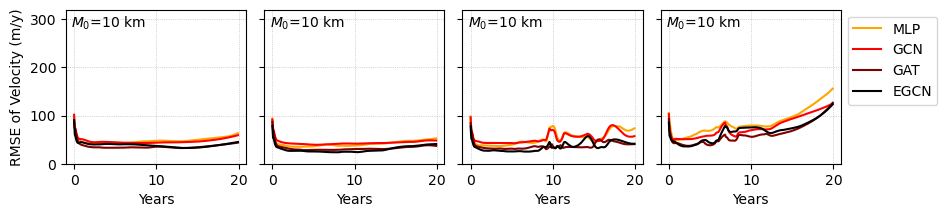

In [112]:
## Channel 3
print(grid)

cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
colors = ["orange", "red", "maroon", "k"]

c = 3
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        if grid == 2468:
            ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
        ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
        if m == 0:
            ax[ci].annotate(f"$M_{0}$={meshsize[grid]} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")

In [155]:
## Mean ice velocity
for grid in [5000, 10000, 20000]:
    print(grid)
    scaling = [5000, 5000, 4000, 3000]
    year_list = [0, 3, 6, 9, 12, 15, 18]
    vmax = [5000, 5000, 2000, 5000]
    vmin = [-5000, -5000, 0, 0]
    verr = [200, 200, 100, 320]
    cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
    channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", ]
    colors = ["orange", "red", "maroon", "k"]
    meshsize = {526: 20, 1112: 10, 2468: 5}

    c = 3
    fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for ci, i in enumerate(test_rates):
        ax[ci].plot(test_years, mean_all["true" + str(grid)][c, ci, :], color = "gray", ls="--", label=f"ISSM")
        for m, model_type in enumerate(model_types):    
            ax[ci].plot(test_years, mean_all[model_type + str(grid)][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
            ax[ci].grid(ls = ":", lw=0.5)
            ax[ci].set_xlabel("Years")
            if grid == 5000:
                ax[ci].set_title(f"r = {int(i*100)} m/y", fontsize = 10)
            # ylim1, ylim2 = ax[ci].set_ylim(0, verr[c])
            if m == 0:
                ax[ci].annotate(f"$M_{0}$={int(grid/1000)} km", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')


    ax[0].set_ylabel("" + channels[c])
    plt.legend(bbox_to_anchor=(1,1), loc = "upper left")

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

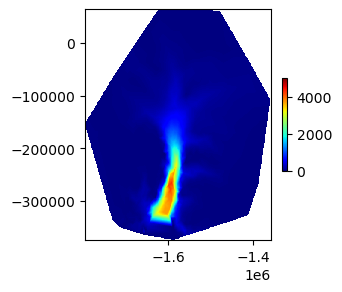

In [467]:
c = 3

vmax = [5000, 5000, 3000, 5000]
vmin = [-5000, -5000, 0, 0]
verr = [200, 200, 80, 100]

plt.figure(figsize = (3,3))
map0 = plt.pcolormesh(gridx, gridy, gridz0, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
# map0 = plt.pcolormesh(gridx, gridy, gridz, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
# map0 = plt.pcolormesh(gridx, gridy, gridz - gridz0, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

plt.colorbar(map0, orientation = "vertical", shrink = 0.4, pad = 0.05)

In [474]:
array = np.zeros([36, 240])
rates = np.arange(0, 72, 2)
years = np.arange(0, 20, 1/12)
xx, yy = np.meshgrid(years, rates)

In [475]:
xx.shape

(36, 240)

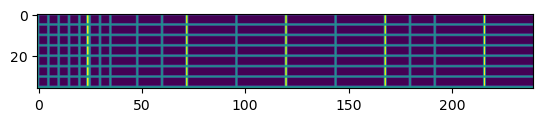

In [484]:

for i, y in enumerate(years):
    if y % 4 == 0:
        array[:, i] = 1
    elif y % 4 == 2:
        array[:, i] = 2
    # plt.plot()
    
for i, r in enumerate(rates):
    if r % 10 == 0:
        array[i, :] = 1
    elif r % 10 == 5:
        array[i, :] = 2
    
# if rate % 200 == 0:

plt.imshow(array)

In [481]:
4.5 % 4

0.5

## Draw error maps (points)

../results/test_torch_dgl_egcn_1112_lr0.01_nophy_ch3.pkl


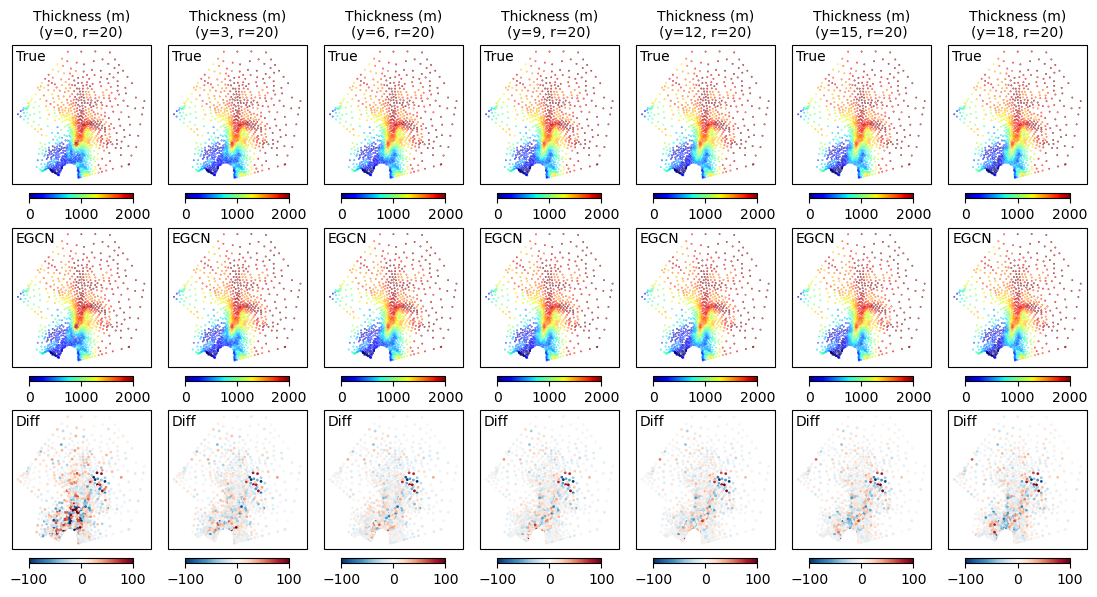

In [274]:
### Channel 3 ###
grid = 10000
files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

filename = files[0]
test = sio.loadmat(filename)

xc = test['S'][0][0][0]
yc = test['S'][0][0][1]

n_nodes = 

model_type = "egcn"

result_file = f"../results/test_torch_dgl_{model_type}_1112_lr0.01_nophy_ch3.pkl"
print(result_file)
with open(result_file, 'rb') as file:
    [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file) 

r = test_rates[1]
c = 2

scaling = [5000, 5000, 4000, 5000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 5000]
verr = [200, 200, 100, 200]
cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]

fig, ax = plt.subplots(3, len(year_list), figsize = (len(year_list)*2, 7), dpi = 100,
                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, y in enumerate(year_list):

    idx = (rates==r) & (years==y)

    obsmap = ax[0, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_true0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    prdmap = ax[1, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    difmap = ax[2, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c] - y_true0[idx, :, c]*scaling[c], s = 1, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

    ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[2, j].annotate(f"Diff", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    ax[0, j].set_title(f"{channels[c]}\n(y={y}, r={int(r*100)})", fontsize = 10)
    
    fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)

In [280]:
x_inputs[idx][:, :, 0][0]

array([0.18922858, 0.1906192 , 0.19584371, ..., 0.09971562, 0.18201835,
       0.21811007])

In [285]:
(y_true0[idx, :, c]*scaling[c]).shape

(1, 1112)

In [309]:
xc.shape

(526, 1)

In [318]:
from scipy.interpolate import griddata

margin = 0

xmax = -1360067.937381 + margin
xmin = -1794277.962227 - margin
ymax = 63667.6809196406 + margin
ymin = -373562.027065861 - margin

gridx, gridy = np.meshgrid(np.arange(xmin, xmax, 500), np.arange(ymin, ymax, 500))
coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
value = (y_true0[idx, :, c]*scaling[c])[0]

grid_z0 = griddata(coord, value,
                   (gridx, gridy), method='linear')

In [12]:
grid = 10000
files = glob.glob(f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat')[:]

filename = files[0]
test = sio.loadmat(filename)

xc = test['S'][0][0][0]
yc = test['S'][0][0][1]

In [320]:
xc.shape

(1112, 1)

<Axes: >

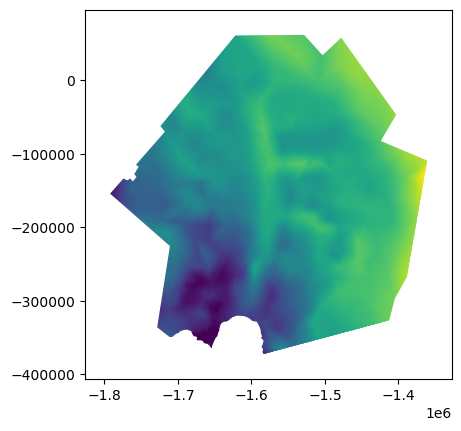

In [347]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(gridx, gridy, grid_z0)
# ax.plot(gdf.X, gdf.Y, color = "r", lw = 2)
outpolygon.plot(
    ax = ax,
    color="white",
    edgecolor="white",
)

In [334]:
## Create outside cilp polygon
from shapely.geometry import box

gdf['shape_id'] = 0
polygon = gdf.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

outpolygon = geopandas.GeoSeries(
    [
        box(*box(*polygon.total_bounds).buffer(100000).bounds).difference(
            polygon["geometry"].values[0]
        )
    ],
    crs=polygon.crs,
)

In [326]:
polygon

shape_id                                           geometry
0         0  POLYGON ((-1712113.018 -349656.021, -1711509.1...

<Axes: >

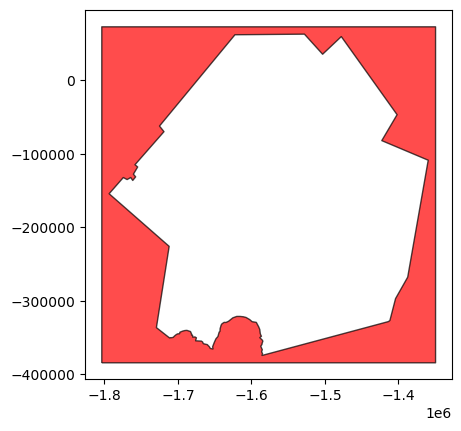

In [333]:
outpolygon.plot(
    color="red",
    edgecolor="black",
    alpha=0.7,
)

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 1112)

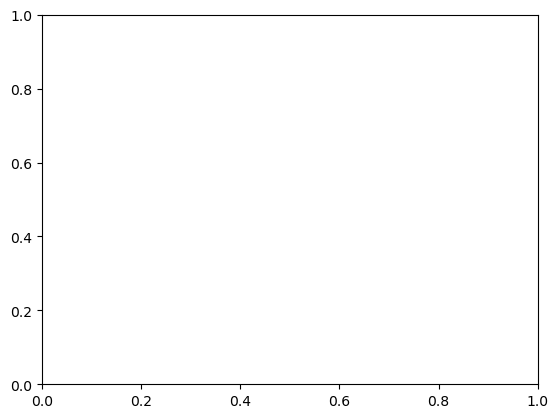

In [276]:
plt.contourf(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1],y_true0[idx, :, c]*scaling[c])

../results/test_torch_dgl_egcn_1112_lr0.01_nophy_ch5.pkl


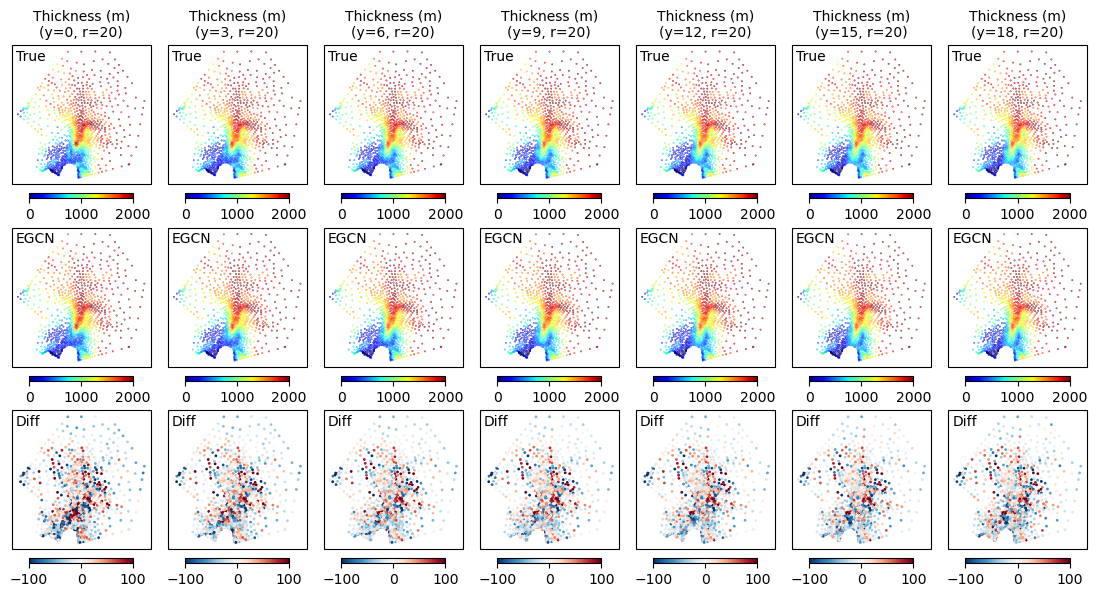

In [158]:
### Channel 5 ###
model_type = "egcn"

result_file = f"../results/test_torch_dgl_{model_type}_1112_lr0.01_nophy_ch5.pkl"
print(result_file)
with open(result_file, 'rb') as file:
    [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file) 

r = test_rates[1]
c = 3

scaling = [5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 5000, 2000, 3000]
vmin = [-5000, -5000, 0, 0, -3000]
verr = [200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]

fig, ax = plt.subplots(3, len(year_list), figsize = (len(year_list)*2, 7), dpi = 100,
                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, y in enumerate(year_list):

    idx = (rates==r) & (years==y)

    obsmap = ax[0, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_true0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    prdmap = ax[1, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    difmap = ax[2, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c] - y_true0[idx, :, c]*scaling[c], s = 1, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

    ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[2, j].annotate(f"Diff", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    ax[0, j].set_title(f"{channels[c]}\n(y={y}, r={int(r*100)})", fontsize = 10)
    
    fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)


In [804]:
y_true0[rates == r].shape
diff = (y_true0[rates == r][1:] - y_true0[rates == r][:-1]) * np.array(scaling)
diff.shape

(239, 1112, 6)

In [715]:
np.sum(smb1)

521.7502905353904

In [716]:
np.sum(diff[100, :, 4])

183.8450520299375

In [718]:
div

tensor([-0.8078, -0.4835,  0.1787,  ...,  0.1275, -0.5194, -0.7762])

In [721]:
torch.sum(adv)

tensor(11315.0312)

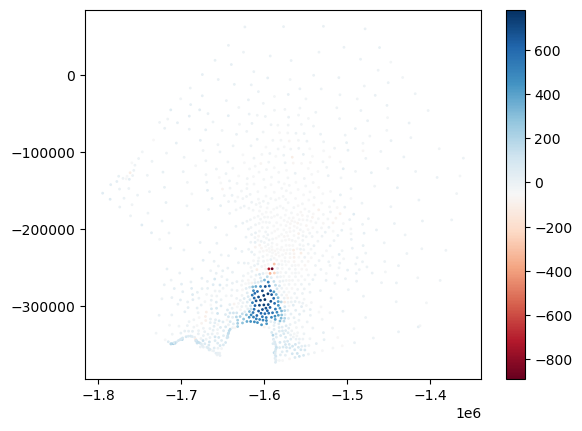

In [666]:
c = 4
plt.scatter(xc, yc, c = y_true0[rates == r][239, :, c]*scaling[c] - y_true0[rates == r][0, :, c]*scaling[c], s= 1, cmap = "RdBu")
plt.colorbar()

In [638]:
smb1 = y_true0[0, :, 0]*scaling[c]
smb2 = y_true0[100, :, 0]*scaling[c]

In [628]:
smb2 = y_true0[idx, :, c]*scaling[c]

In [703]:
def divergence(nodes, edges, u, v, h, x, y):
    div = torch.zeros(nodes.shape)
    adv = torch.zeros(nodes.shape)
    
    for n1 in nodes:
        ind = torch.where(edges[0] == n1)[0]
        cnt = len(ind)
        for i in ind:
            n2 = edges[1][i.item()]
            if abs(x[n2]-x[n1]) > 0:
                adv[n1] += (u[n1]*(h[n2]-h[n1])/(x[n2]-x[n1]))/cnt
                div[n1] += (h[n1]*(u[n2]-u[n1])/(x[n2]-x[n1]))/cnt
            if abs(y[n2]-y[n1]) > 0:
                adv[n1] += (v[n1]*(h[n2]-h[n1])/(y[n2]-y[n1]))/cnt
                div[n1] += (h[n1]*(v[n2]-v[n1])/(y[n2]-y[n1]))/cnt

            if abs(adv[n1].item()) > 1000:
                print(n1, n2 , "H: ", h[n2].item()-h[n1].item(), "U: ", u[n2].item()-u[n1].item(), "V: ", v[n2].item()-v[n1].item(),
                      "X/Y: ", x[n2]-x[n1], y[n2]-y[n1], adv[n1].item(), div[n1].item())
                
    return div/12, adv/12

In [727]:
p1 = np.array([1, 2, 3])
p2 = np.array([4, 6, 9])
p3 = np.array([12, 11, 9])

# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)
a, b, c = cp

## Calculate divergence with finite element

In [112]:
def get_gradient(v1, v2, v3):
    # input: vector 1, vector 2, vector 3 (3 dimension of [x, y, z]; z should be height, u or v velocity, etc.)
    a1 = v3 - v1
    a2 = v2 - v1
    a, b, c = torch.cross(a1, a2)
    # Plane equation: ax + by + cz = d --> cz = -ax - by + d
    # dz/dx = -a/c
    # dz/dy = -b/c
    dzdx = -a/c
    dzdy = -b/c
    return dzdx, dzdy
    

def div_nodes(nodes, elements, u, v, h, x, y):
    div = torch.zeros(nodes.shape) #torch.zeros(elements.shape[0])
    adv = torch.zeros(nodes.shape) # torch.zeros(elements.shape[0])
    count = torch.zeros(nodes.shape)
    area = torch.zeros(nodes.shape)
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        h1 = torch.tensor([x[p1], y[p1], h[p1]])
        h2 = torch.tensor([x[p2], y[p2], h[p2]])
        h3 = torch.tensor([x[p3], y[p3], h[p3]])
        dhdx, dhdy = get_gradient(h1, h2, h3)
        
        u1 = torch.tensor([x[p1], y[p1], u[p1]])
        u2 = torch.tensor([x[p2], y[p2], u[p2]])
        u3 = torch.tensor([x[p3], y[p3], u[p3]])
        dudx, dudy = get_gradient(u1, u2, u3)
        
        v1 = torch.tensor([x[p1], y[p1], v[p1]])
        v2 = torch.tensor([x[p2], y[p2], v[p2]])
        v3 = torch.tensor([x[p3], y[p3], v[p3]])
        dvdx, dvdy = get_gradient(v1, v2, v3)
        
        dive = (h[p1]+h[p2]+h[p3])/3*(dudx+dvdy) # divergence of element
        adve = (u[p1]+u[p2]+u[p3])/3*dhdx + (v[p1]+v[p2]+v[p3])/3*dhdy # advection of element
        
        adv[p1] += adve
        div[p1] += dive
        adv[p2] += adve
        div[p3] += dive
        adv[p1] += adve
        div[p3] += dive
        
        count[p1] += 1
        count[p2] += 1
        count[p3] += 1
        
        i += 1        
    
    adv = adv / count
    div = div / count
    
    return div/12, adv/12

def div_elements(nodes, elements, u, v, h, x, y):
    div = torch.zeros(elements.shape[0]) #torch.zeros(elements.shape[0])
    adv = torch.zeros(elements.shape[0]) # torch.zeros(elements.shape[0])
    count = torch.zeros(elements.shape[0])
    area = torch.zeros(elements.shape[0])
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        h1 = torch.tensor([x[p1], y[p1], h[p1]])
        h2 = torch.tensor([x[p2], y[p2], h[p2]])
        h3 = torch.tensor([x[p3], y[p3], h[p3]])
        dhdx, dhdy = get_gradient(h1, h2, h3)
        
        u1 = torch.tensor([x[p1], y[p1], u[p1]])
        u2 = torch.tensor([x[p2], y[p2], u[p2]])
        u3 = torch.tensor([x[p3], y[p3], u[p3]])
        dudx, dudy = get_gradient(u1, u2, u3)
        
        v1 = torch.tensor([x[p1], y[p1], v[p1]])
        v2 = torch.tensor([x[p2], y[p2], v[p2]])
        v3 = torch.tensor([x[p3], y[p3], v[p3]])
        dvdx, dvdy = get_gradient(v1, v2, v3)
        
        dive = (h[p1]+h[p2]+h[p3])/3*(dudx+dvdy) # divergence of element
        adve = (u[p1]+u[p2]+u[p3])/3*dhdx + (v[p1]+v[p2]+v[p3])/3*dhdy # advection of element
        
        adv[i] = adve
        div[i] = dive
        area[i] = 0.5 * abs(x[p1]*(y[p2]-y[p3]) + x[p2]*(y[p3]-y[p1]) + x[p3]*(y[p1]-y[p2]))
        xx[i] = (x[p1] + x[p2] + x[p3])/3
        yy[i] = (y[p1] + y[p2] + y[p3])/3
        
        count[i] += 1

        i += 1        
    
    adv = adv
    div = div
    
    return div, adv, area, xx, yy

def mean_elements(nodes, elements, org, x, y):
    output = torch.zeros(elements.shape[0])
    count = torch.zeros(elements.shape[0])
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        
        output[i] = (org[p1] + org[p2] + org[p3])/3
        
        count[i] += 1
        
        i += 1        
    
    return output

In [1]:
test_set = ISSM_test_dataset()

g0 = test_set[0]
g = test_set[1]
u = g.ndata['label'][:, 0] * 5000
v = g.ndata['label'][:, 1] * 5000
h = g.ndata['label'][:, 3] * 4000
h0 = g0.ndata['label'][:, 3] * 4000
f = g.ndata['label'][:, 4]

xmax = -1360067.937381
xmin = -1794277.962227
ymax = 63667.6809196406
ymin = -373562.027065861

smb = g.ndata['feat'][:, 4]
r = g.ndata['feat'][:, 2] * 100
x = g.ndata['feat'][:, 0] * (xmax-xmin) + xmin
y = g.ndata['feat'][:, 1] * (ymax-ymin) + ymin

nodes = g.nodes()
edges = g.edges()

# smb = mean_elements(nodes, elements, smb, x, y)
# r = mean_elements(nodes, elements, r, x, y)
# f = mean_elements(nodes, elements, f, x, y)
# h = mean_elements(nodes, elements, h, x, y)
# h0 = mean_elements(nodes, elements, h0, x, y)
# dh = (h - h0)*12

# # div, adv = div_nodes(nodes, elements, u, v, h, x, y)
# div, adv, area, xx, yy = div_elements(nodes, elements, u, v, h, x, y)

NameError: name 'ISSM_test_dataset' is not defined

In [323]:
g = test_set[200]
r = g.ndata['feat'][:, 3]

In [324]:
r

tensor([0.8333, 0.8333, 0.8333,  ..., 0.8333, 0.8333, 0.8333])

In [352]:
print("Melting rate: ", torch.sum(r[f < 0]).item())
print("SMB: ", torch.sum(smb).item())
print("Ms-Mb=", torch.sum(smb).item() - torch.sum(r[f < 0]).item())
print("Advection: ", torch.sum(adv).item())
print("dh/dt: ", torch.sum(dh).item())
print(torch.sum(adv) + torch.sum(dh))

Melting rate:  0.0
SMB:  1002.6613159179688
Ms-Mb= 1002.6613159179688
Advection:  -728.97705078125
dh/dt:  3811.00732421875
tensor(3082.0303)


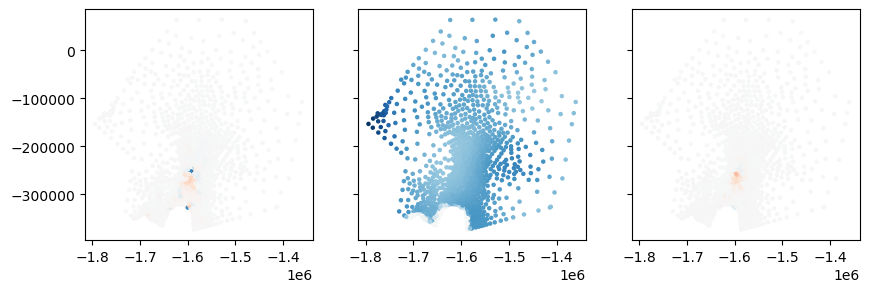

In [345]:
fig, ax = plt.subplots(1,3, figsize = (10, 3), sharey = True)
ax[0].scatter(x, y, c = dh, s=5, vmin = -100, vmax = 100, cmap = "RdBu")
ax[1].scatter(x, y, c = smb, s=5, vmin = -1, vmax = 1, cmap = "RdBu")
ax[2].scatter(x, y, c = adv, s=5, vmin = -100, vmax = 100, cmap = "RdBu")

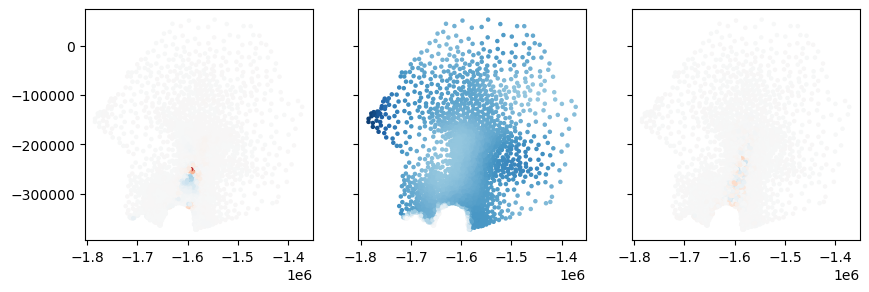

In [356]:
fig, ax = plt.subplots(1,3, figsize = (10, 3), sharey = True)
ax[0].scatter(xx, yy, c = dh, s=5, vmin = -1000, vmax = 1000, cmap = "RdBu")
ax[1].scatter(xx, yy, c = smb, s=5, vmin = -1, vmax = 1, cmap = "RdBu")
ax[2].scatter(xx, yy, c = adv, s=5, vmin = -500, vmax = 500, cmap = "RdBu")

In [193]:
torch.sum(g.ndata['feat'][:, 4])

tensor(1169.7433)

In [230]:
torch.sum(adv)

tensor(-14819.9248)

In [224]:
torch.sum(dh)

tensor(266.3144)

In [25]:
class ISSM_train_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_train_dataset_g20000.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
class ISSM_test_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_test_dataset_g20000.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
test_set = ISSM_test_dataset()
train_set = ISSM_train_dataset()

g0 = test_set[0]
g = test_set[1]
u = g.ndata['label'][:, 0] * 5000
v = g.ndata['label'][:, 1] * 5000
h = g.ndata['label'][:, 3] * 4000
h0 = g0.ndata['label'][:, 3] * 4000
f = g.ndata['label'][:, 4]

xmax = -1360067.937381
xmin = -1794277.962227
ymax = 63667.6809196406
ymin = -373562.027065861

smb = g.ndata['feat'][:, 4]
r = g.ndata['feat'][:, 2] * 100
x = g.ndata['feat'][:, 0] * (xmax-xmin) + xmin
y = g.ndata['feat'][:, 1] * (ymax-ymin) + ymin

nodes = g.nodes()
edges = g.edges()

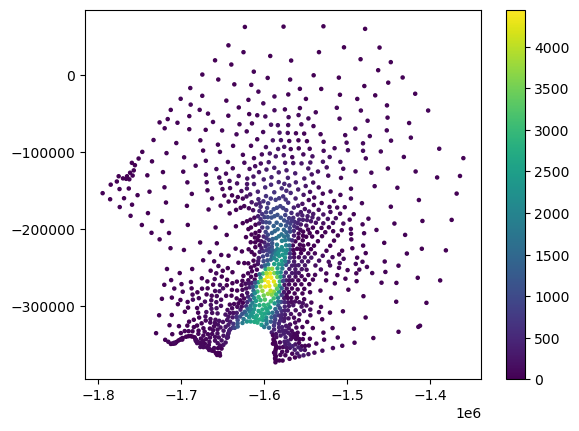

In [679]:
plt.scatter(x, y, c = (u**2 + v**2)**0.5, s= 5)
plt.colorbar()

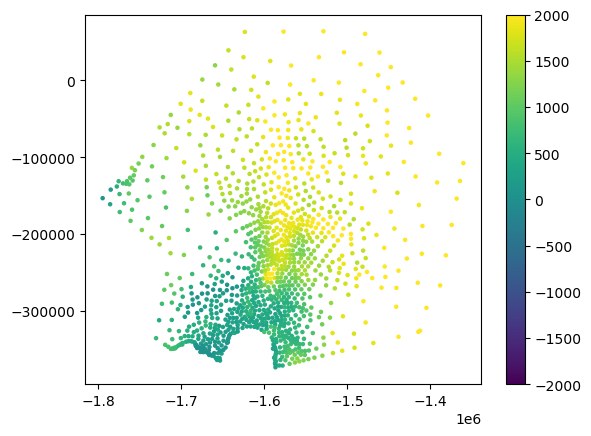

In [550]:
plt.scatter(x, y, c = h, s= 5, vmax = 2000, vmin = -2000)
plt.colorbar()

In [10]:
x.shape

torch.Size([526])

In [22]:
margin = 0

xmax = -1360067.937381 + margin
xmin = -1794277.962227 - margin
ymax = 63667.6809196406 + margin
ymin = -373562.027065861 - margin

gridx, gridy = np.meshgrid(np.arange(xmin, xmax, 500), np.arange(ymin, ymax, 500))
coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
value = yc[:, 0]

grid_z0 = griddata(coord, value, (gridx, gridy), method='linear')

<Axes: >

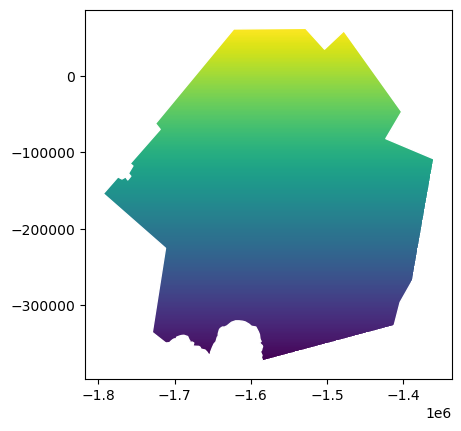

In [23]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(gridx, gridy, grid_z0)
# ax.plot(gdf.X, gdf.Y, color = "r", lw = 2)
outpolygon.plot(
    ax = ax,
    color="white",
    edgecolor="white",
)

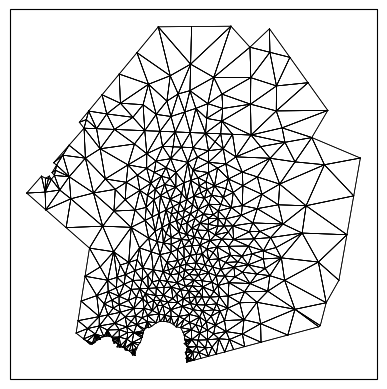

In [28]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "k", lw = 0.5, zorder=1)

# ax.scatter(x, y, c = np.arange(0, len(x)), s = 20, zorder=2)

In [38]:
edges[20]

IndexError: tuple index out of range

In [70]:
edges[0]

tensor([  0,   0,   0,  ..., 525, 525, 525])

In [85]:
edges[1][np.where(edges[0] == 482)]

tensor([161, 135,  79, 163, 161,  80, 376, 163,  80, 107, 135, 376,  79, 107])

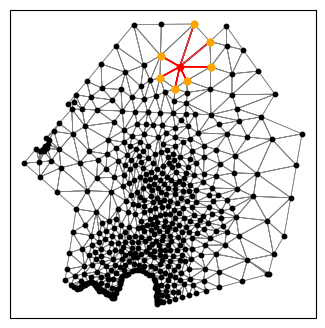

In [93]:
fig, ax = plt.subplots(1,1, figsize = (4,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

k = 163 #100, 80, 161, 482, 376

ax.scatter(x, y, c = "k", s = 10, zorder=2)
ax.scatter(x[k], y[k], c = "r", s = 20, zorder=2)

for i in range(0, len(edges[0])):
    if k == edges[0][i].item():
        ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "r", lw = 1, zorder=1)
        ax.scatter(x[edges[1][i]], y[edges[1][i]], c = "orange", s = 20, zorder=2)
    if k == edges[1][i].item():
        ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "r", lw = 1, zorder=1)
        ax.scatter(x[edges[0][i]], y[edges[0][i]], c = "orange", s = 20, zorder=2)
    else:
        ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)



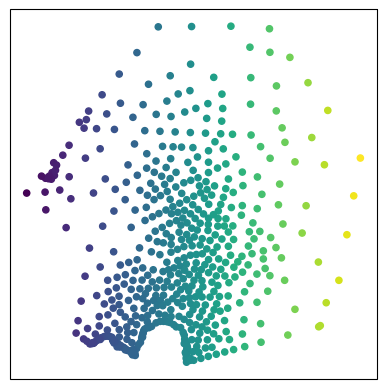

In [6]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

# for i in range(0, len(edges[0])):
#     ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = x, s = 20, zorder=2)

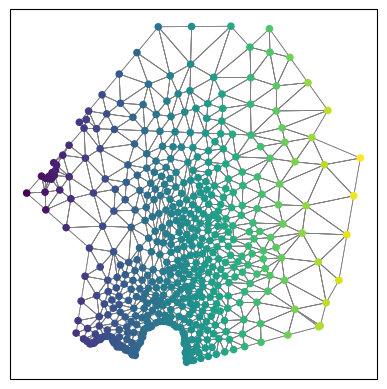

In [5]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = x, s = 20, zorder=2)

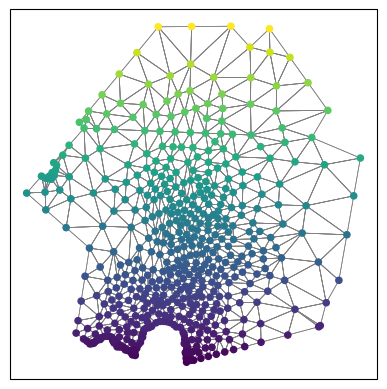

In [18]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = y, s = 20, zorder=2)

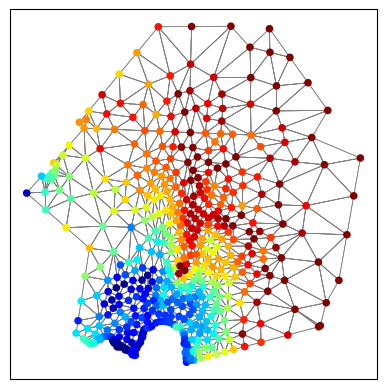

In [21]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = h, s = 20, zorder=2, cmap = "jet", vmin = 0, vmax = 2000)

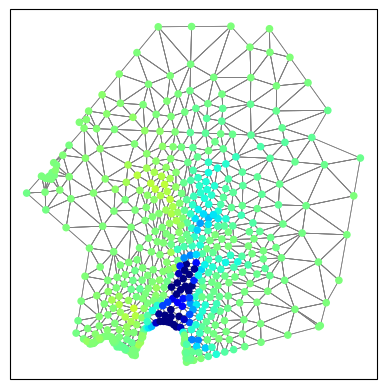

In [28]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = u, s = 20, zorder=2, cmap = "jet", vmin = -1000, vmax = 1000)

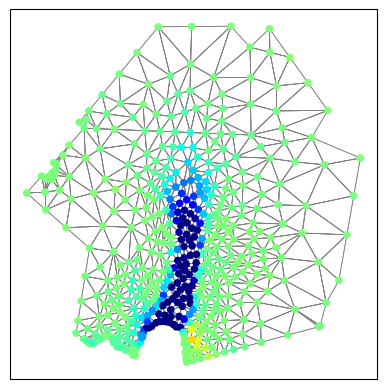

In [27]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "gray", lw = 0.5, zorder=1)

ax.scatter(x, y, c = v, s = 20, zorder=2, cmap = "jet", vmin = -1000, vmax = 1000)

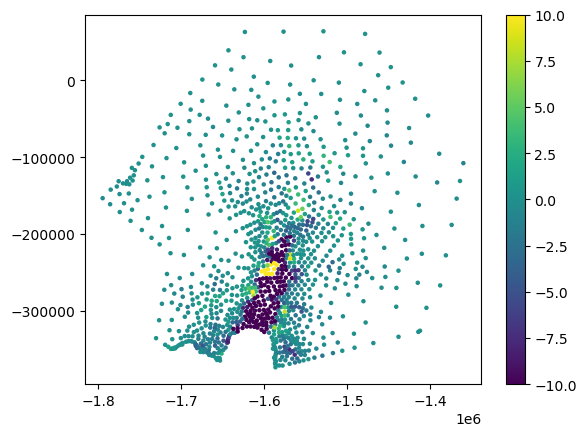

In [794]:
plt.scatter(x, y, c = adv, s= 5, vmin = -10, vmax = 10)
plt.colorbar()

In [798]:
torch.sum(torch.tensor(diff[0, :, 4])*12 + adv + div)

tensor(60.9782, dtype=torch.float64)

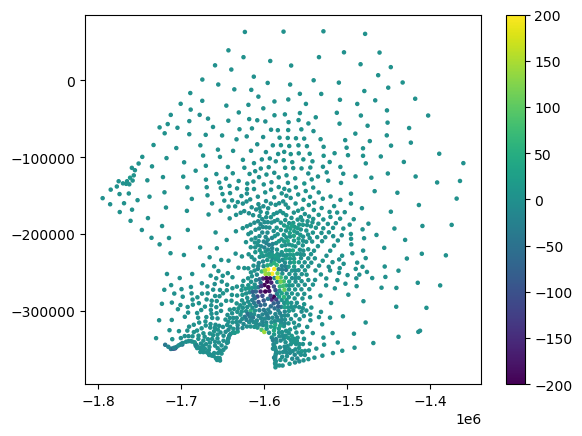

In [821]:
plt.scatter(x, y, c = adv + div, s=5, vmin = -200, vmax = 200)
plt.colorbar()

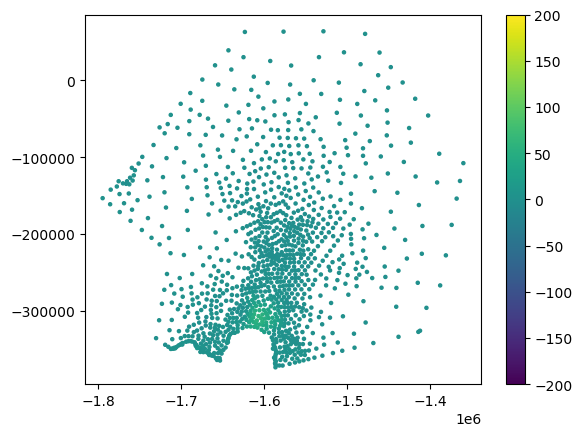

In [831]:
plt.scatter(x, y, c = torch.tensor(diff[100, :, 4])*12, s= 5, vmin = -200, vmax = 200)
plt.colorbar()

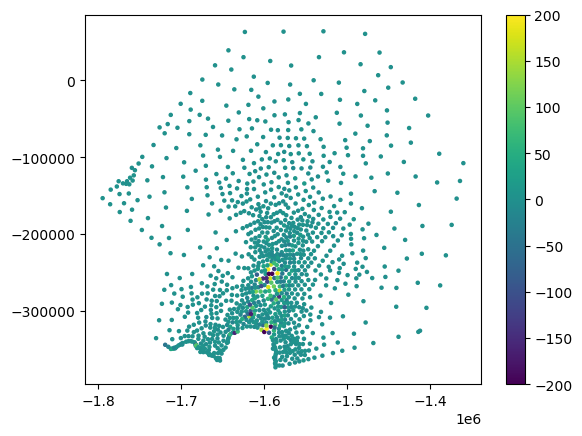

In [824]:
plt.scatter(x, y, c = torch.tensor(diff[0, :, 4])*12 + adv + div, s= 5, vmin = -200, vmax = 200)
plt.colorbar()

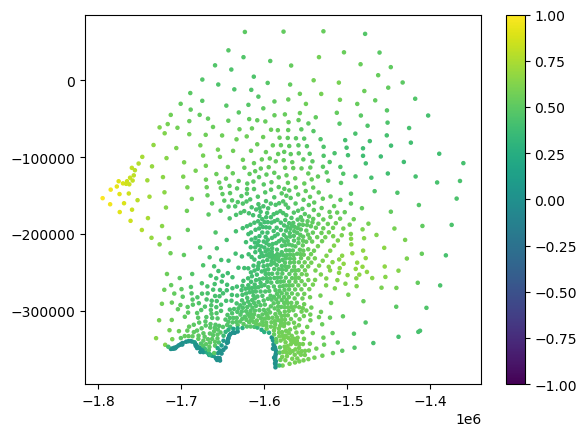

In [695]:
plt.scatter(x, y, c = smb1, s= 5, vmin = -1, vmax = 1)
plt.colorbar()

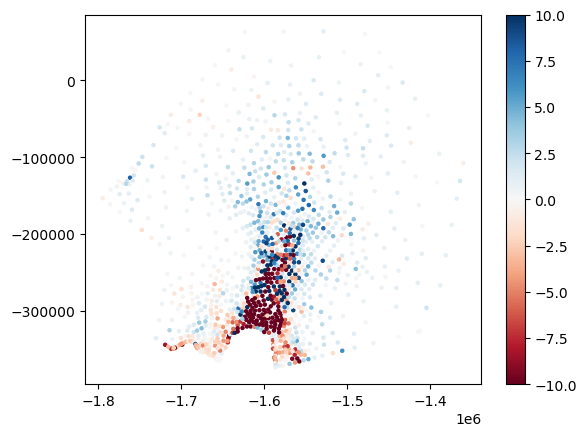

In [773]:
plt.scatter(x, y, c = adv+div, s= 5, vmin = -10, vmax = 10, cmap = "RdBu")
plt.colorbar()

In [612]:
smb[0] / 1112

array([1.57793150e-05, 2.11620204e-05, 0.00000000e+00, ...,
       6.89326719e-04, 3.57085029e-04, 0.00000000e+00])

In [614]:
elements.shape

(2085, 3)

In [618]:
edges[0].shape

torch.Size([12510])

In [506]:
dot

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [476]:
ind = torch.where(g.edges()[0] == n)[0]

In [479]:
i.item()

1613

In [482]:
g.edges()[0][i.item()]

tensor(200)

In [42]:
test_rates

array([0.        , 0.2       , 0.40000001, 0.60000002])

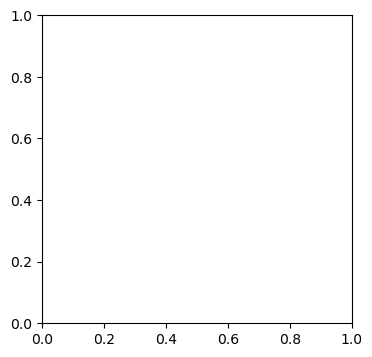

In [158]:
plt.subplots(1,1, figsize = (4,4))
year = 2022
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

time_train = pd.DataFrame({})

for grid in [526, 1112, 2468]:
    for i, model in enumerate(["egcn", "gcn", "mlp", "gat", "fcn"]):
        if model == "fcn":
            model_name = f"torch_dgl_{model}_{grid}_lr0.001_nophy_ch3"
        else:
            model_name = f"torch_dgl_{model}_{grid}_lr0.01_nophy_ch3"
        with open(f'../model/history_{model_name}.pkl', 'rb') as file:
            history = pickle.load(file)
        time_train.loc[grid, model] = history['time'][-1]
        

#         plt.plot(history['loss'], color = colors[i], label = f"Train loss ({model})")
#         plt.plot(history['val_loss'], color = colors[i], ls = "--", label = f"Val loss ({model})")

#         print(history['loss'][-1], history['val_loss'][-1])
#     # plt.xlim(0, 50)
    
# plt.legend(bbox_to_anchor=(1,1))
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# # plt.yscale('log')
# plt.grid(ls = ":", lw = 0.5)

In [159]:
time_train

egcn          gcn         mlp          gat          fcn
526    779.581842   618.800439  116.698036   700.224083  4462.480248
1112  1611.039373  1270.963501  206.811751  1300.687165  4468.248195
2468  2954.718485  1488.910725  411.842059  1982.861179  4467.088694

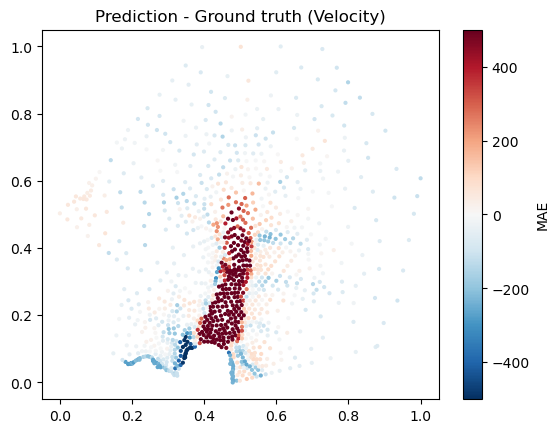

In [26]:
model_type = "gcn"
result_file = f"../results/test_torch_{model_type}_lr0.001_nophy_gpu.pkl"

with open(result_file, 'rb') as file:
    [rates, years, y_true0, y_pred0] = pickle.load(file)  

ind = 10
c = 3

channels = ["SMB", "U velocity", "V velocity", "Velocity", "Thickness"]
vmax = [1, 400, 400, 4000, 2000]
vmin = [0, -400, -400, 0, 0]

err = np.mean((y_pred0 - y_true0), axis=0)
plt.title(f"Prediction - Ground truth ({channels[c]})")
plt.scatter(xc, yc, c = err[:, c], s = 4, cmap = "RdBu_r", vmin = -500, vmax = 500)
plt.colorbar(label = "MAE")

In [32]:
y_true.shape

(1, 1112, 5)

IndexError: list index out of range

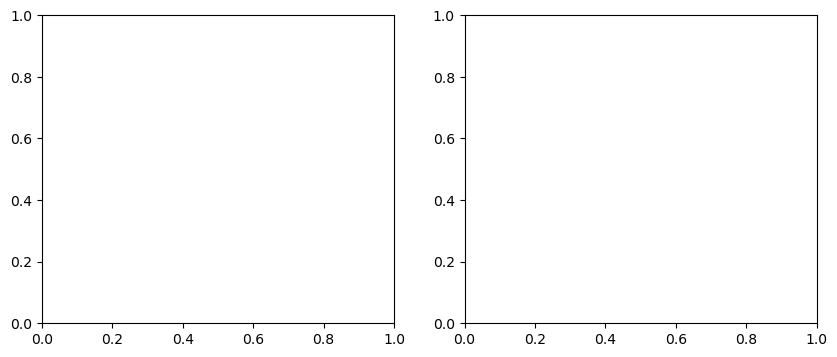

In [232]:
ind = 1200
c = 5
err = np.mean(abs(y_pred - y_true), axis=0)


fig, ax = plt.subplots(1,2, figsize = (10,4))
c1 = ax[0].scatter(xc, yc, c = y_true[0, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[0].set_title(f"True {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[0])
c2 = ax[1].scatter(xc, yc, c = y_pred[0, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[1].set_title(f"Predicted {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[1])

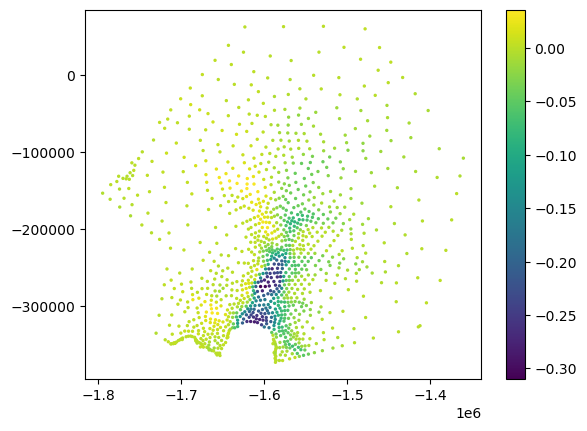

In [57]:
plt.scatter(xc, yc, c = vx[0]/5000, s = 2)
plt.colorbar()

205964106.30591267
205776418.05709606
205591376.5088661
205418323.7494367
205256813.25122318


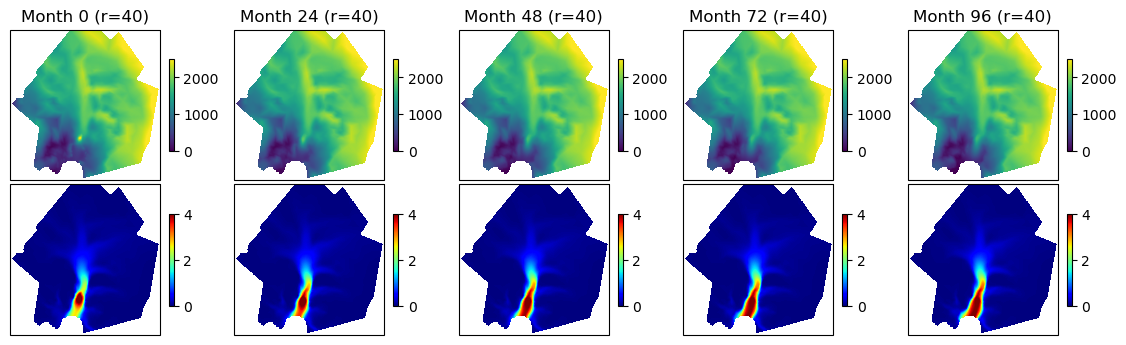

In [111]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r40.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol40 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel40 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=40)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205968118.00278923
205910434.94427702
205842919.99588054
205773103.6475761
205704447.55447897


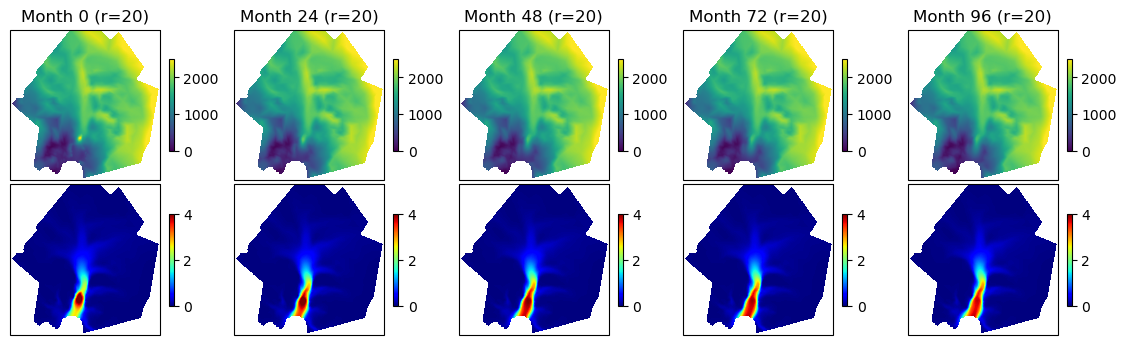

In [110]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r20.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol20 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel20 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=20)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205970126.9921308
205978459.7669149
205974605.06885847
205963737.60910466
205945981.8779817


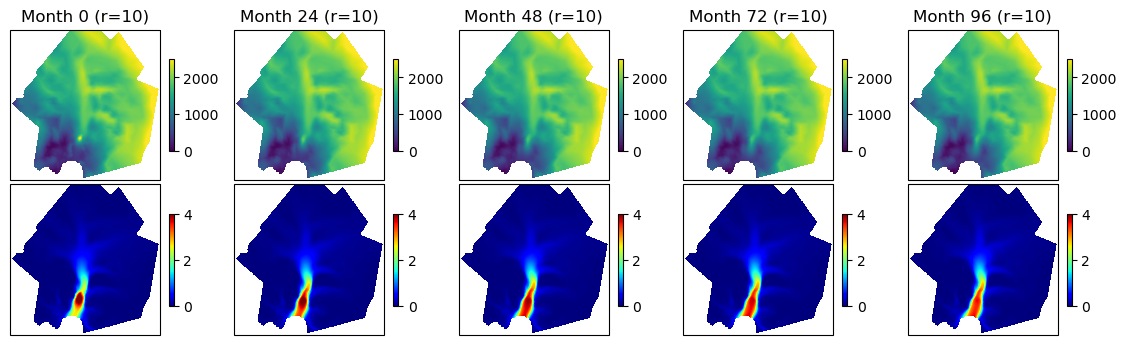

In [122]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r10.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol10 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel10 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=10)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205971131.48680156
206012976.71163708
206041501.56193674
206060713.93202695
206071883.7007757


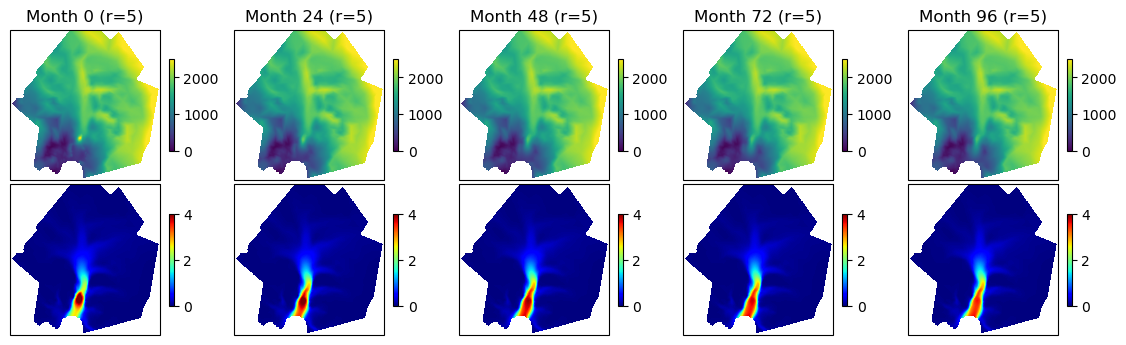

In [109]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r5.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol05 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel05 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=5)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

Text(0, 0.5, 'Total ice volume ($km^3$)')

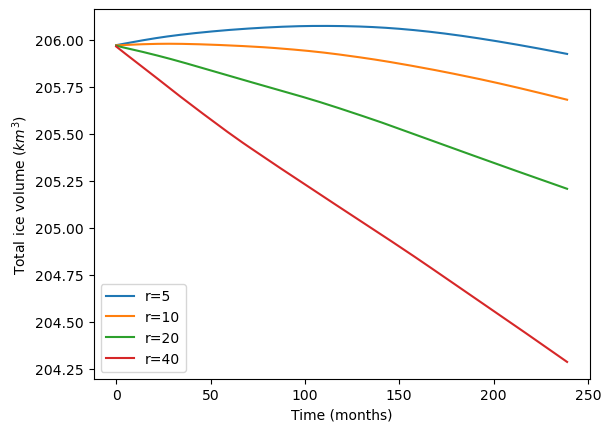

In [120]:
plt.plot(ice_vol05/1000000, label = "r=5")
plt.plot(ice_vol10/1000000, label = "r=10")
plt.plot(ice_vol20/1000000, label = "r=20")
plt.plot(ice_vol40/1000000, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Total ice volume ($km^3$)")

Text(0, 0.5, 'Mean ice velocity (m/year)')

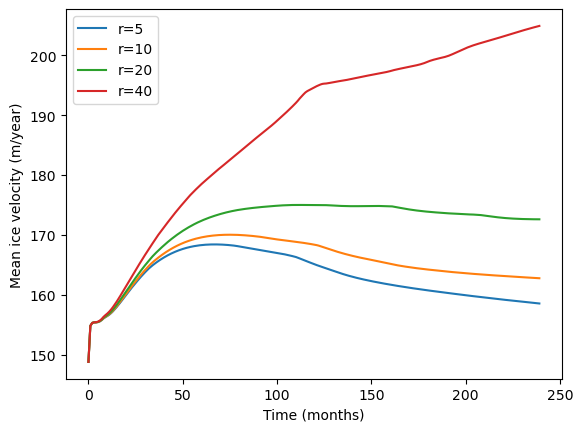

In [121]:
plt.plot(ice_vel05, label = "r=5")
plt.plot(ice_vel10, label = "r=10")
plt.plot(ice_vel20, label = "r=20")
plt.plot(ice_vel40, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Mean ice velocity (m/year)")

## Visualize Pine Island Glaciers

In [146]:
ncfile = "D:\\ISSM\\Antarctica_ice_velocity.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    # sic = np.array(nc.variables['cdr_seaice_conc'])[0] # CDR SIC
    # xs = np.array(nc.variables['x'])[:]
    # ys = np.array(nc.variables['y'])[:] 
    # xx, yy = np.meshgrid(xs, ys)
    # x = np.array(nc.variables['x'])[:]
    # y = np.array(nc.variables['y'])[:]
    vx = np.array(nc.variables['vx'])[:]
    vy = np.array(nc.variables['vy'])[:]
    g_attdict = nc.__dict__
    # for k,v in g_attdict.iteritems():
    #     print(k, type(v))     
    print(nc.variables, nc.ncattrs())

{'vx': <class 'netCDF4._netCDF4.Variable'>
float32 vx(ny, nx)
    Content: Ice velocity in x direction
    Units:   meter/year
unlimited dimensions: 
current shape = (6223, 6223)
filling on, default _FillValue of 9.969209968386869e+36 used, 'vy': <class 'netCDF4._netCDF4.Variable'>
float32 vy(ny, nx)
    Content: Ice velocity in y direction
    Units:   meter/year
unlimited dimensions: 
current shape = (6223, 6223)
filling on, default _FillValue of 9.969209968386869e+36 used, 'err': <class 'netCDF4._netCDF4.Variable'>
int8 err(ny, nx)
    Content: Error estimate for magnitude of ice velocities
    Units:   meter/year
    Comment: See Rignot et al. 2011 for more information
unlimited dimensions: 
current shape = (6223, 6223)
filling on, default _FillValue of -127 ignored} ['Title', 'Version', 'nx', 'ny', 'Projection', 'Ellipsoid', 'Longitude_of_origin', 'Latidude_of_origin', 'Secant_latitude', 'xmin', 'ymax', 'spacing', 'Summary_1', 'Summary_2', 'Notes_1', 'Reference', 'Notes_2', 'Data_

In [227]:
ncfile = "D:\\ISSM\\Antarctica_5km_withshelves_v0.75.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    g_attdict = nc.__dict__
    # for k,v in g_attdict.iteritems():
    #     print(k, type(v))   
    h = np.array(nc.variables['thk'])[:]
    sf = np.array(nc.variables['usrf'])[:]
    lat = np.array(nc.variables['lat'])[:]
    lon = np.array(nc.variables['lon'])[:]
    print(nc.variables['usrf'])
    # print(nc.variables, nc.ncattrs())
    
crs2 = 'epsg:3031' # Coordinate system of the file
crs1 = 'epsg:4326' # Global lat-lon coordinate system

latlon2polar = pyproj.Transformer.from_crs(crs1, crs2)
xh, yh = latlon2polar.transform(lat, lon)

xh = xh[0]
yh = yh[0]
h = h[0]
sf = sf[0]

<class 'netCDF4._netCDF4.Variable'>
float32 usrf(time, y1, x1)
    Source: (Provided by J.A. Griggs and J.L. Bamber) [1] Bamber, J.L., J.L. Gomez-Dans and J.A. Griggs (2009), "A New 1 km Digital Elevation Model of the Antarctic Derived From Combined Satellite Radar and Laser Data - Part 1: Data and Methods"; The Cryosphere, 3, 101-111, 2009.  [2] Griggs, J.A. and J.L. Bamber (2009), "A New 1 km Digital Elevation Model of Antarctica Derived From Combined Radar and Laser Data - Part 2: Validation and Error Estimates"; The Cryosphere, 3, 113-123 2009.
    long_name: Ice Upper Surface Elevation
    standard_name: surface_altitude
    units: meters
unlimited dimensions: 
current shape = (1, 1200, 1200)
filling on, default _FillValue of 9.969209968386869e+36 used


In [187]:
m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
xh, yh = m(lon, lat)
xh = xh[0]
yh = yh[0]
h = h[0]

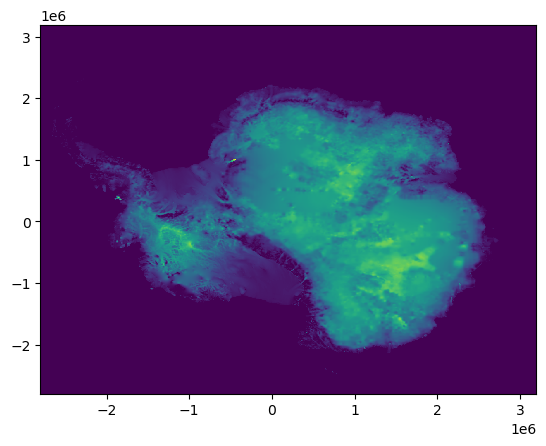

In [217]:
plt.pcolormesh(xh, yh, h)

In [43]:
x = np.arange(-2800000, 2800000, 900)
y = np.arange(-2800000, 2800000, 900)
xx, yy = np.meshgrid(x, -y)

In [70]:
import rasterio

In [86]:
# Read Sentinel-2 image using raterio
img_name = "D:\\ISSM\\LIMA_0.5_ATCM.13000.tif"
img = rasterio.open(img_name)
array = img.read()

height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# XY projected coordinate of the image
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)

img.close()

In [92]:
img.transform

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [93]:
np.transpose(array).shape

(36000, 25200, 3)

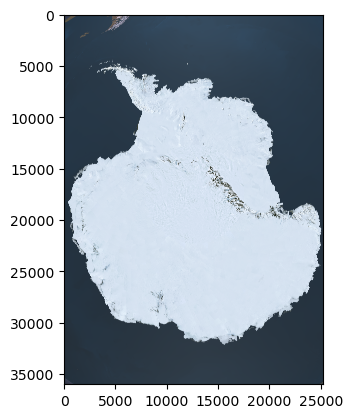

In [94]:
plt.imshow(np.transpose(array))

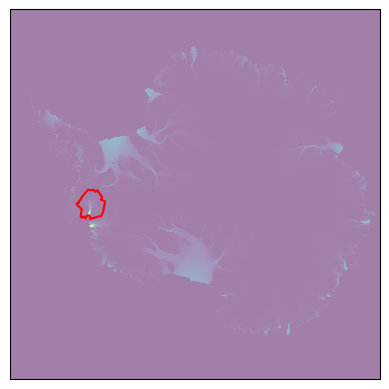

In [69]:
# m = Basemap(projection='spstere',boundinglat=-10,lon_0=0)

# m.drawcoastlines(color = "k", linewidth=1)
# m.fillcontinents(color='lightgray',lake_color='white')
# # draw parallels and meridians.
# # m.drawparallels(np.arange(-80.,81.,20.))
# # m.drawmeridians(np.arange(-180.,181.,20.))
# # m.drawmapboundary(fill_color='white')
# # draw tissot's indicatrix to show distortion.
# ax = plt.gca()

# xgrid, ygrid = m(lon, lat)
    
# #     # Grid sampling
# #     ugrid2, vgrid2 = rotate_vector(ugrid, vgrid, lon)
# #     xsam, ysam, usam, vsam = grid_sampling(xgrid, ygrid, ugrid2, vgrid2, 150000)
# #     xx, yy = np.meshgrid(xsam, ysam)
    
# #     power = (ugrid**2 + vgrid**2)**0.5
#     sc = ax.contourf(xgrid, ygrid, t2m-273.15, cmap='Oranges',
#                      vmin = -32, vmax = 0, levels = np.arange(-32, 1, 2), extend = "both")

fig, ax = plt.subplots(1,1, dpi = 100, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax[0, k].coastlines('10m', linewidth = 0.5)
ax.pcolormesh(xx, yy, (vx**2+vy**2)**0.5, alpha = 0.5)
ax.plot(gdf.X, gdf.Y, color = "r")

In [101]:
m(0, -90)

(-10691802.4658631, -10691802.4658631)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


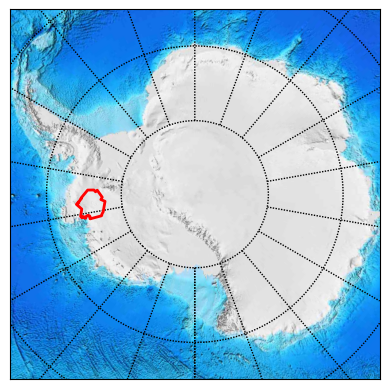

In [144]:

# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
# m.drawcoastlines()
# m.bluemarble()
m.etopo()
# m.shadedrelief()
ax = plt.gca()

m.drawparallels(np.arange(-80.,81.,10.), lw = 0.5)
m.drawmeridians(np.arange(-180.,181.,20.), lw = 0.5)

# m.imshow((u**2+v**2)**0.5, alpha = 0.5)
offset = -10691802.4658631

# ax.pcolormesh(xx+offset, yy+offset, (vx**2+vy**2)**0.5, alpha = 0.5)
ax.plot(gdf.X+offset, gdf.Y+offset, color = "r", lw = 2)

ax.set_xlim(-2800000.0+offset, 2800000.0+offset)
ax.set_ylim(-2800000.0+offset, 2800000.0+offset)


plt.show()

In [117]:
xx

array([[-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800],
       [-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800],
       [-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800],
       ...,
       [-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800],
       [-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800],
       [-2800000, -2799100, -2798200, ...,  2798000,  2798900,  2799800]])

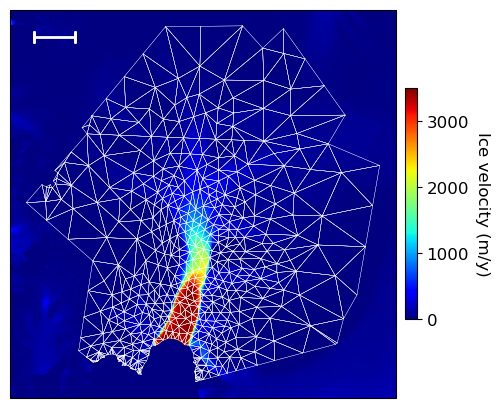

In [231]:

# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
# # m.drawcoastlines()
# # m.bluemarble()
# # m.etopo()
# # m.shadedrelief()
# ax = plt.gca()
# m.imshow((u**2+v**2)**0.5, alpha = 0.5)


offset = -10691802.4658631
margin = 20000

xmax = -1360067.937381 + margin
xmin = -1794277.962227 - margin
ymax = 63667.6809196406 + margin
ymin = -373562.027065861 - margin


fig, ax = plt.subplots(1,1, figsize = (6, 6), subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})

# m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
# ax = plt.gca()



pc = ax.pcolormesh(xx+offset, yy+offset, (vx**2+vy**2)**0.5, cmap = "jet", vmin=0, vmax = 3500)
# ax.plot(gdf.X+offset, gdf.Y+offset, color = "r")

clb = fig.colorbar(pc, shrink=0.50, pad = 0.02)
clb.set_label('Ice velocity (m/y)', rotation = 270, fontsize = 12, va = 'bottom')
clb.ax.tick_params(labelsize=12)

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]]+offset, x[edges[1][i]]+offset], [y[edges[0][i]]+offset, y[edges[1][i]]+offset], color = "white", lw = 0.2)

# Scale bar

plt.errorbar([xmin+30000+offset, xmin+80000+offset], [50000+offset, 50000+offset], xerr = 2, capsize = 4, capthick = 2, lw = 2, color = "white")

ax.plot()
ax.set_xlim(xmin+offset, xmax+offset)
ax.set_ylim(ymin+offset, ymax+offset)

plt.show()

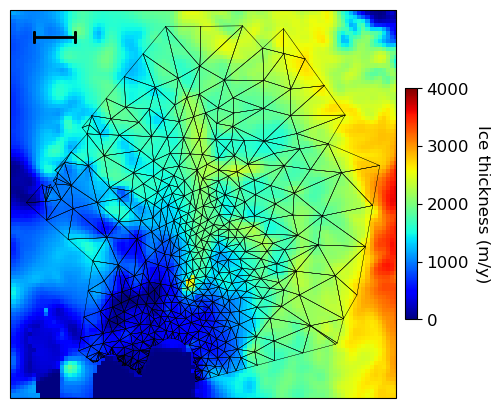

In [242]:

offset = -10691802.4658631
margin = 20000

xmax = -1360067.937381 + margin
xmin = -1794277.962227 - margin
ymax = 63667.6809196406 + margin
ymin = -373562.027065861 - margin


fig, ax = plt.subplots(1,1, figsize = (6, 6), subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})

# m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
# ax = plt.gca()

pc = ax.pcolormesh(xh+offset, yh+offset, h, cmap = "jet", vmin=0, vmax=4000)
# pc = ax.pcolormesh(xx+offset, yy+offset, (vx**2+vy**2)**0.5, cmap = "jet", vmin=0, vmax = 3500)
# ax.plot(gdf.X+offset, gdf.Y+offset, color = "r")

clb = fig.colorbar(pc, shrink=0.50, pad = 0.02)
clb.set_label('Ice thickness (m/y)', rotation = 270, fontsize = 12, va = 'bottom')
clb.ax.tick_params(labelsize=12)

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]]+offset, x[edges[1][i]]+offset], [y[edges[0][i]]+offset, y[edges[1][i]]+offset], color = "k", lw = 0.2)

# Scale bar

plt.errorbar([xmin+30000+offset, xmin+80000+offset], [50000+offset, 50000+offset], xerr = 2, capsize = 4, capthick = 2, lw = 2, color = "k")

ax.plot()
ax.set_xlim(xmin+offset, xmax+offset)
ax.set_ylim(ymin+offset, ymax+offset)

plt.show()

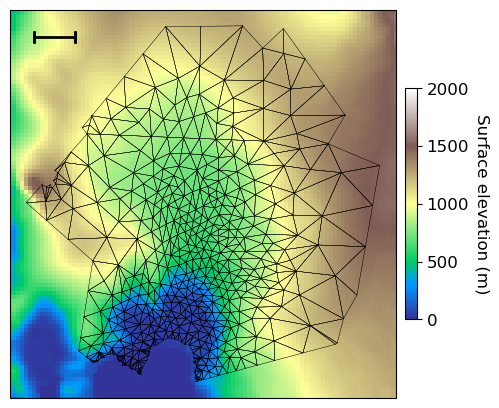

In [228]:

offset = -10691802.4658631
margin = 20000

xmax = -1360067.937381 + margin
xmin = -1794277.962227 - margin
ymax = 63667.6809196406 + margin
ymin = -373562.027065861 - margin


fig, ax = plt.subplots(1,1, figsize = (6, 6), subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})

# m = Basemap(projection='spstere', boundinglat=-10,lon_0=0,resolution='l')
# ax = plt.gca()

pc = ax.pcolormesh(xh+offset, yh+offset, sf, cmap = "terrain", vmin = 0, vmax = 2000)
# pc = ax.pcolormesh(xx+offset, yy+offset, (vx**2+vy**2)**0.5, cmap = "jet", vmin=0, vmax = 3500)
# ax.plot(gdf.X+offset, gdf.Y+offset, color = "r")

clb = fig.colorbar(pc, shrink=0.50, pad = 0.02)
clb.set_label('Surface elevation (m)', rotation = 270, fontsize = 12, va = 'bottom')
clb.ax.tick_params(labelsize=12)

for i in range(0, len(edges[0])):
    ax.plot([x[edges[0][i]]+offset, x[edges[1][i]]+offset], [y[edges[0][i]]+offset, y[edges[1][i]]+offset], color = "k", lw = 0.2)

# Scale bar

plt.errorbar([xmin+30000+offset, xmin+80000+offset], [50000+offset, 50000+offset], xerr = 2, capsize = 4, capthick = 2, lw = 2, color = "k")

ax.plot()
ax.set_xlim(xmin+offset, xmax+offset)
ax.set_ylim(ymin+offset, ymax+offset)

plt.show()

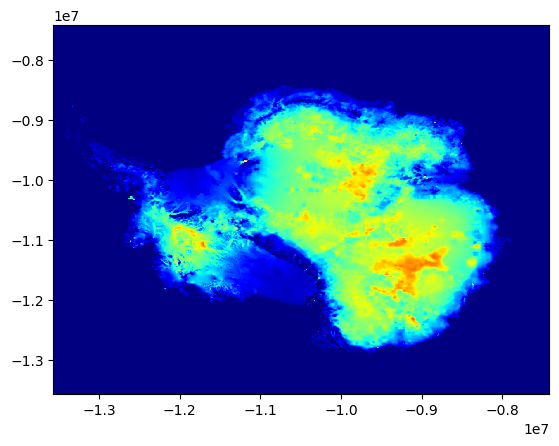

In [196]:
plt.pcolormesh(xh, yh, h, cmap = "jet")

<ErrorbarContainer object of 3 artists>

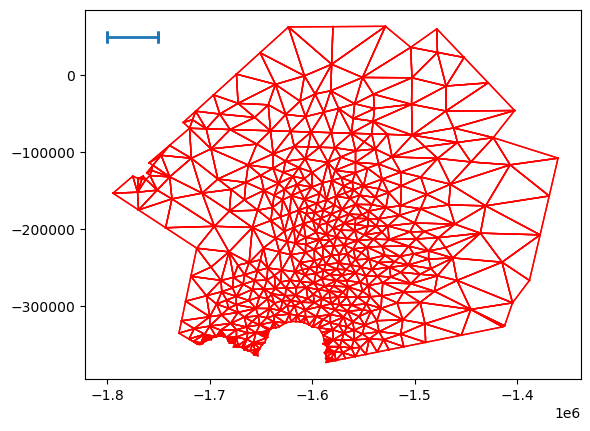

In [154]:
for i in range(0, len(edges[0])):
    plt.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "r", lw = 1)
plt.errorbar([-1750000, -1800000], [50000, 50000], xerr = 2, capsize = 4, capthick = 2, lw = 2)

In [6]:
# Variable: Path to .exp file
text = "D:\\ISSM\\DomainOutline.exp"

# Process: Open .exp file for reading
file = open(text, 'r')

# Process: Read first line of .exp file
line = file.readline()
print(line)
# # Process: Decode line
# .exp = line.decode('utf-16', 'ignore')

# # Message: Return message to display
# print exp

# Process: Close file object
file.close()



## Name:



In [51]:
df = pd.DataFrame()

In [45]:
t[9].split()

['-1705459.7700022999', '-347193.5996532570']

In [132]:
with open(text, 'r') as f:
    t = f.readlines()

for i, x in enumerate(t[5:-1]):
    
    df.loc[i, "X"] = float(x.split()[0])
    df.loc[i, "Y"] = float(x.split()[1])
    # print(x)

NameError: name 'text' is not defined

In [131]:
from shapely.geometry import Point, LineString, shape

#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)


NameError: name 'df' is not defined

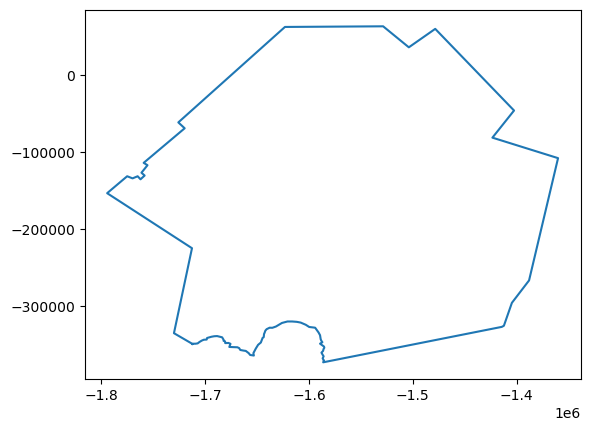

In [60]:
plt.plot(gdf.X, gdf.Y)